# TabNet으로 하는 Classification: Deep Dive

출처: [https://syslog.ravelin.com/classification-with-tabnet-deep-dive-49a0dcc8f7e8](https://syslog.ravelin.com/classification-with-tabnet-deep-dive-49a0dcc8f7e8)

# Classification with TabNet: Deep Dive

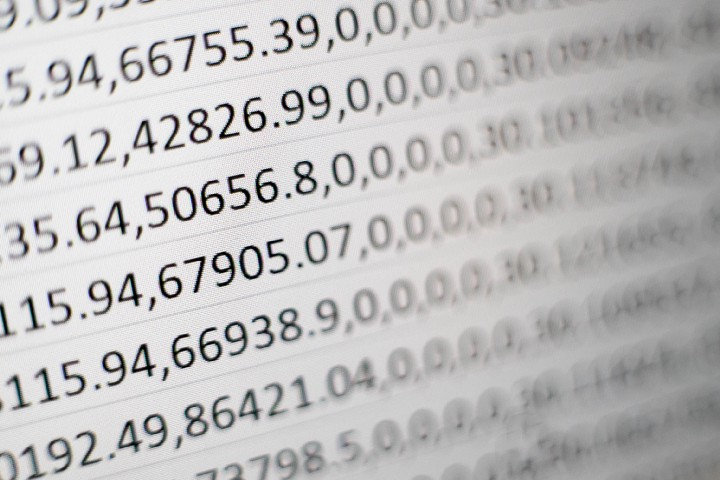

여기서는 해석 가능하고 테이블 형식 데이터와 잘 작동하도록 설계된 TabNet ([Arik & Pfister(2019)](https://arxiv.org/abs/1908.07442))이라는 neural architecture에 대해 자세히 알아볼 것입니다. 핵심 building block과 그 이면의 아이디어를 설명한 후, TensorFlow에서 구현하는 방법과 사기 탐지 데이터 세트에 적용하는 방법을 알 수 있습니다. 대부분의 코드는 [여기](https://github.com/aruberts/blogs/blob/main/TabNet%20Classification%20Example.ipynb)에서 가져왔습니다.

# TabNet
TabNet은 Sequential Attention의 아이디어를 사용하여 decision tree의 동작을 모방합니다. 간단히 말해서 각 단계에서 두 가지 주요 작업을 적용하는 multi-step neural network로 생각할 수 있습니다:

1. Attentive Transformer는 다음 단계에서 처리할 가장 중요한 feature를 선택합니다.

2. Feature Transformer는 feature를 보다 유용한 표현으로 처리합니다.

Feature Transformer의 output은 나중에 예측에 사용됩니다. Attentive와 Feature Transformer를 모두 사용하여 TabNet은 tree-based model의 의사 결정 프로세스를 시뮬레이션할 수 있습니다.

모델은 해석 가능성과 학습을 향상시키는 task에 가장 유용한 feature를 선택하고 처리할 수 있습니다.

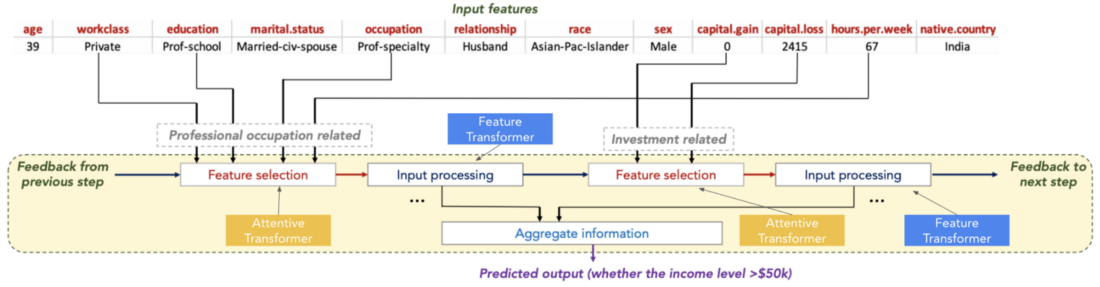

Attentive와 Feature Transformer의 key building block은 Feature Blocks입니다. 이제 이들을 살펴봅시다.

# Feature Blocks
Feature Block은 순차적으로 적용된 FC (Fully-Connected)(or Dense) layer와 Batch Normalization (BN)으로 구성됩니다. 또한, Feature Transformers의 경우 output이 GLU activation layer를 통과합니다.

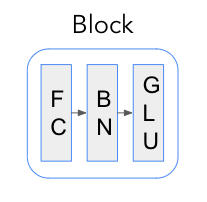

GLU(sigmoid gate와 반대)의 주요 기능은 hidden unit이 모델에 더 깊이 전달되도록 하고, gradient exploding이나 vanishing을 방지하는 것입니다.

In [ ]:
def glu(x, n_units=None):
    """Generalized linear unit nonlinear activation."""
    return x[:, :n_units] * tf.nn.sigmoid(x[:, n_units:])

또한, 원본 논문은 training 중 convergence speed를 향상시키기 위해 Ghost Batch Normalization을 사용합니다. 관심이 있는 경우, [여기](https://github.com/ostamand/tensorflow-tabnet/blob/master/tabnet/models/gbn.py)에서 Tensorflow implementation을 찾을 수 있지만, 이 tutorial에서는 default Batch Normalization layer를 사용합니다.

In [ ]:
class FeatureBlock(tf.keras.Model):
    """
    Implementation of a FL->BN->GLU block
    """
    def __init__(
        self,
        feature_dim,
        apply_glu = True,
        bn_momentum = 0.9,
        fc = None,
        epsilon = 1e-5,
    ):
        super(FeatureBlock, self).__init__()
        self.apply_gpu = apply_glu
        self.feature_dim = feature_dim
        units = feature_dim * 2 if apply_glu else feature_dim # desired dimension gets multiplied by 2
                                                              # because GLU activation halves it

        self.fc = tf.keras.layers.Dense(units, use_bias=False) if fc is None else fc # shared layers can get re-used
        self.bn = tf.keras.layers.BatchNormalization(momentum=bn_momentum, epsilon=epsilon)

    def call(self, x, training = None):
        x = self.fc(x) # inputs passes through the FC layer
        x = self.bn(x, training=training) # FC layer output gets passed through the BN
        if self.apply_gpu: 
            return glu(x, self.feature_dim) # GLU activation applied to BN output
        return x

# Feature Transformers
FeatureTransformer(FT)는 기본적으로 순차적으로 적용되는 feature blocks의 collection입니다. 논문에서 하나의 FeatureTransformer는 2개의 shared blocks(즉, weight은 steps에서 재사용)과 2개의 step dependent blocks으로 구성됩니다. shared weights는 모델의 parameters를 줄이고 더 나은 일반화로 이어집니다.

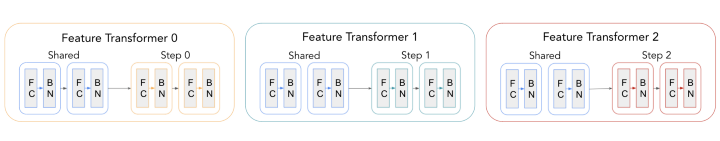

이전 section의 Feature Block 구현을 고려하여, Feature Transformer를 구축하는 방법은 다음과 같습니다.

In [ ]:
class FeatureTransformer(tf.keras.Model):
    def __init__(
        self,
        feature_dim,
        fcs = [],
        n_total = 4,
        n_shared = 2,
        bn_momentum = 0.9,
    ):
        super(FeatureTransformer, self).__init__()
        self.n_total, self.n_shared = n_total, n_shared

        kwrgs = {
            "feature_dim": feature_dim,
            "bn_momentum": bn_momentum,
        }

        # build blocks
        self.blocks = []
        for n in range(n_total):
            # some shared blocks
            if fcs and n < len(fcs):
                self.blocks.append(FeatureBlock(**kwrgs, fc=fcs[n])) # Building shared blocks by providing FC layers
            # build new blocks
            else:
                self.blocks.append(FeatureBlock(**kwrgs)) # Step dependent blocks without the shared FC layers

    def call(self, x, training = None):
        # input passes through the first block
        x = self.blocks[0](x, training=training) 
        # for the remaining blocks
        for n in range(1, self.n_total):
            # output from previous block gets multiplied by sqrt(0.5) and output of this block gets added
            x = x * tf.sqrt(0.5) + self.blocks[n](x, training=training) 
        return x

    @property
    def shared_fcs(self):
        return [self.blocks[i].fc for i in range(self.n_shared)]

# Attentive Transformer
AT(Attentive Transformer)는 각 step에서 feature selection을 담당합니다. feture selection은 prior scale을 고려하면서 (GLU 대신) sparsemax activation를 적용하여 수행됩니다. prior scale를 사용하면 모델에서 feature를 선택할 수 있는 빈도를 제어할 수 있으며, 이전 단계에서 사용된 빈도에 따라 제어할 수 있습니다.

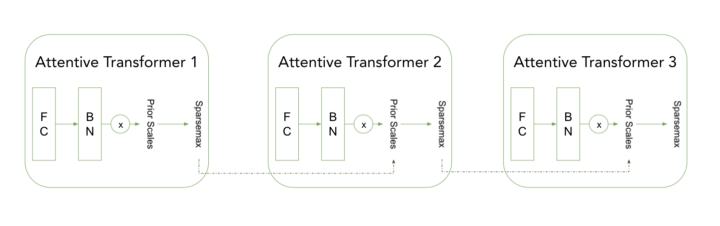

이전 Attention Transformer는 이전 step에서 사용된 feature에 대한 정보를 따라 prior scale로 전달됩니다. Feature Transformer와 유사하게, Attentive Transformer는 나중에 더 큰 아키텍처에 통합될 TensorFlow 모델로 구현될 수 있습니다.

In [ ]:
class AttentiveTransformer(tf.keras.Model):
    def __init__(self, feature_dim):
        super(AttentiveTransformer, self).__init__()
        self.block = FeatureBlock(
            feature_dim,
            apply_glu=False, # sparsemax instead of glu
        )

    def call(self, x, prior_scales, training=None):
        # Pass input trhough a FC-BN block
        x = self.block(x, training=training)
        # Pass the output through sparsemax activation
        return sparsemax(x * prior_scales)

Feature와 Attentive Transformer block은 parameter가 상당히 무거울 수 있으므로 TabNet은 몇 가지 메커니즘을 사용하여 복잡성을 제어하고 overfitting을 방지합니다.

# Regularisation

## Prior Scales Calculation
Prior scales(P)를 사용하면 모델에서 feature를 선택할 수 있는 빈도를 제어할 수 있습니다. prior scale(P)은 이전 Attentive Transformer activation 및 relaxation factor($γ$) parameter를 사용하여 계산됩니다. 다음은 논문에 제시된 공식입니다.

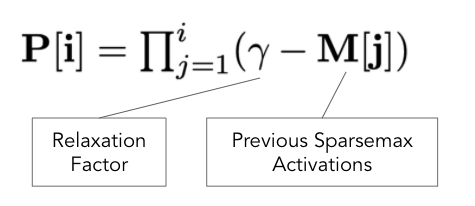

이 방정식은 prior scales가 어떻게 업데이트되는지 보여줍니다. 업데이트는 현재 step $i$까지의 모든 단계에 대한 product입니다. 직관적으로, 이전 steo에서 feature가 사용된 경우, 모델은 overfitting을 줄이기 위해 나머지 feature에 더 많은 주의를 기울입니다.

예를 들어, $γ$=1일 때 multiplicative activations(예: 0.9)가 있는 feature는 작은 prior scales(1–0.9=0.1)를 갖습니다.

## Sparsity regularisation
loss에 대한 sparsity regularization은 attention mask가 sparse하도록 장려하기 위해 사용됩니다. hyperparameter $λ$에 의해 스케일링된 entropy of activations는 전체 모델 loss에 추가됩니다.

In [ ]:
def sparse_loss(at_mask):
    loss = tf.reduce_mean(
        tf.reduce_sum(tf.multiply(-at_mask, tf.math.log(at_mask + 1e-15)),
                      axis=1)
    )
    
    return loss

not_sparse_mask = np.array([[0.4, 0.5, 0.05, 0.05],
                      [0.2, 0.2, 0.5, 0.1]])

sparse_mask = np.array([[0.0, 0.0, 0.7, 0.3],
                      [0.0, 0.0, 1, 0.0]])

print('Loss for non-sparse attention mask:', sparse_loss(not_sparse_mask).numpy())
print('Loss for sparse attention mask:', sparse_loss(sparse_mask).numpy())

# Loss for non-sparse attention mask: 1.1166351874690217
# Loss for sparse attention mask: 0.3054321510274452

다음으로 이러한 구성 요소를 사용하여 TabNet 모델을 구축하는 방법을 알아보겠습니다.

# TabNet Architecture

## Putting It All Together

TabNet의 기본 아이디어는 Feature 및 Attentive Transformers 구성 요소가 순차적으로 적용되어 모델이 decision tree를 만드는 과정을 모방할 수 있다는 것입니다. Attentive Transformer는 feature selection을 수행하고 Feature Transformer는 모델이 데이터의 복잡한 패턴을 학습할 수 있도록 하는 transformations를 수행합니다. 아래에서 2-step TabNet 모델에 대한 data flow를 요약한 다이어그램을 볼 수 있습니다.

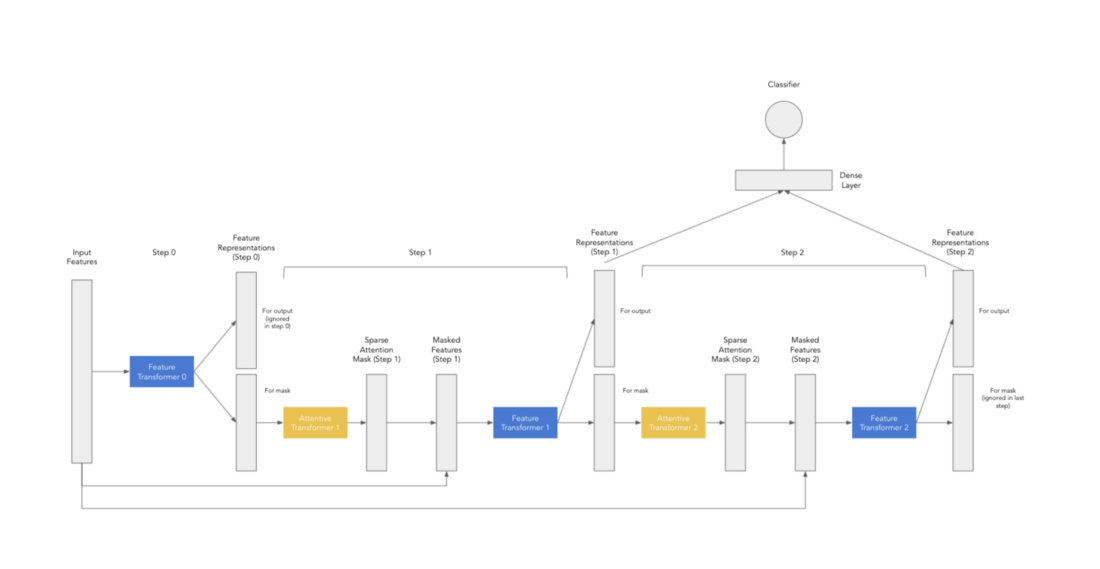

우선 초기 input features를 Feature Transformer를 통해 전달하여 초기 feature representations를 얻습니다. 이 Feature Transformer의 output은 다음 단계로 전달할 features의 subset을 선택하는 Attentive Transformer에 대한 input으로 사용됩니다. 이 프로세스는 필요한 단계 수만큼 반복됩니다. (이 [code snippet](https://gist.github.com/aruberts/5e97edb8e8d1820db70b427c7ee74995)에서 위에 정의된 클래스를 사용하여 TensorFlow 구현을 볼 수 있습니다)

모델은 각 decision step의 Feature Transformer output을 사용하여 최종 예측을 생성합니다. 또한 각 step에서 attention mask를 집계하여 예측에 사용된 feature를 이해할 수 있습니다. 이러한 mask는 global importances뿐만 아니라 local feature importances를 얻는 데 사용할 수 있습니다.

<br/>

이제 실습을 시작해봅시다.

# 실습: Fraud Detectioin

## imports

In [6]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders.woe import WOEEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import average_precision_score, roc_auc_score, confusion_matrix
from tensorflow_addons.activations import sparsemax
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns

## Data

([데이터 경로](https://www.kaggle.com/competitions/ieee-fraud-detection/data))

데이터가 2개로 나뉘어 있기 때문에, merge가 필요합니다

In [13]:
train_transactions = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')

# merge two datasets
train = pd.merge(train_transactions, train_identity, on='TransactionID', how='left')
train['isFraud'].value_counts(normalize=True)

0    0.98441
1    0.01559
Name: isFraud, dtype: float64

In [14]:
test_transactions = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')

# merge two datasets
test = pd.merge(test_transactions, test_identity, on='TransactionID', how='left')
test.columns = [c.replace('-', '_') for c in test.columns]

## Feature Engineering
feature engineering은 fraud detection 영역에서 가장 중요한 단계입니다. 그러나 이 프로젝트의 주요 목표가 아니므로 이 단계를 건너뛰고 독자에게 맡기겠습니다.

In [15]:
# Make an hour feature from datetime stamp 
def make_hour_feature(f):
    #Creates an hour of the day feature, encoded as 0-23.  
    hours = f / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

train['hour'] = make_hour_feature(train['TransactionDT'])
test['hour'] = make_hour_feature(test['TransactionDT'])

## Data Cleaning

- missing values가 많은 칼럼 제거

- median 값을 missing values에 채워넣기

- categorical 칼럼의 missing values에 "missing"이란 값으로 채워 넣기

In [16]:
cat_features = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
               'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1',
               'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo',
               'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
               'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
               'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

exclude = ['TransactionID', 'TransactionDT', 'isFraud']
num_features = [f for f in train.columns if (f not in cat_features) & (f not in exclude)]

# 결측치 90% 이상 칼럼 제거
col_na = train.isnull().sum()
to_drop = col_na[(col_na /  train.shape[0]) > 0.9].index

use_cols = [f for f in train.columns if f not in to_drop]
cat_features = [f for f in cat_features if f not in to_drop]
num_features = [f for f in num_features if f not in to_drop]

train[cat_features] = train[cat_features].astype(str)
train[num_features] = train[num_features].astype(np.float)
train = train[use_cols]

test[cat_features] = test[cat_features].astype(str)
test[num_features] = test[num_features].astype(np.float)
test = test[[f for f in use_cols if f != 'isFraud']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [17]:
from sklearn.impute import SimpleImputer
# median 값 채워 넣기

train[num_features] = SimpleImputer(strategy="median").fit_transform(train[num_features])
train[cat_features] = train[cat_features].replace("nan", "missing")
train.isnull().sum().sum()

0

In [18]:
test[num_features] = SimpleImputer(strategy="median").fit_transform(test[num_features])
test[cat_features] = test[cat_features].replace("nan", "missing")
test.isna().sum().sum()

0

In [19]:
train.shape

(898, 423)

## Train/Val Split
testing은 미래 시점에 수행되므로 validationi split은 datetime 칼럼을 사용하여 수행합니다.

In [20]:
train_split = train["TransactionDT"] <= np.quantile(train["TransactionDT"], 0.9)

In [21]:
train_X = train.loc[train_split.values, num_features + cat_features]
train_y = train.loc[train_split.values, "isFraud"]

val_X = train.loc[~train_split.values, num_features + cat_features]
val_y = train.loc[~train_split.values, "isFraud"]

In [22]:
print(len(train_X), 'train examples')
print(len(val_X), 'validation examples')

808 train examples
90 validation examples


## Pre-processing
neural network는 숫자 데이터만 처리할 수 있으므로 input을 전처리해야 합니다. 아래 코드는 매우 단순화한 전처리 파이프라인이며 categoy embeddings와 같은 보다 정교한 방법 바꿀 수 있습니다.

- numeric features 스케일링

- categorical features 인코딩

In [23]:
scaler = StandardScaler()
woe = WOEEncoder()
column_trans = ColumnTransformer(
    [("scaler", scaler, num_features),
     ("woe", woe, cat_features)], remainder="passthrough", n_jobs=-1
)

train_X_transformed = column_trans.fit_transform(train_X, train_y)
val_X_transformed = column_trans.transform(val_X)

In [24]:
test_X_transformed = column_trans.transform(test[num_features + cat_features])
print(train_X_transformed.shape, val_X_transformed.shape, test_X_transformed.shape)

(808, 420) (90, 420) (1834, 420)


In [25]:
train_X_transformed = pd.DataFrame(train_X_transformed, columns=[num_features + cat_features])
val_X_transformed = pd.DataFrame(val_X_transformed, columns=[num_features + cat_features])
test_X_trinsformed = pd.DataFrame(test_X_transformed, columns=[num_features + cat_features])

## TF Data
training과 inference를 더 빠르게 하려면 데이터를 TF Data object로 변환해야 합니다.

In [26]:
def prepare_tf_dataset(X, batch_size, y=None, shuffle=False, drop_remainder=False):
    size_of_dataset = len(X)
    if y is not None:
        y = tf.one_hot(y.astype(int), 2)
        ds = tf.data.Dataset.from_tensor_slices((np.array(X.astype(np.float32)), y))
    else:
        ds = tf.data.Dataset.from_tensor_slices(np.array(X.astype(np.float32)))
    if shuffle:
        ds = ds.shuffle(buffer_size=size_of_dataset)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    
    autotune = tf.data.experimental.AUTOTUNE
    ds = ds.prefetch(autotune)
    return ds

train_ds = prepare_tf_dataset(train_X_transformed, 16384, train_y)
val_ds = prepare_tf_dataset(val_X_transformed, 16384, val_y)
test_ds = prepare_tf_dataset(test_X_transformed, 16384)

## Model

### TabNet

위에서 언급한 클래스를 모두 정의

In [27]:
def glu(x, n_units=None):
    """Generalized linear unit nonlinear activation."""
    return x[:, :n_units] * tf.nn.sigmoid(x[:, n_units:])

In [28]:
class FeatureBlock(tf.keras.Model):
    """
    Implementation of a FL->BN->GLU block
    """
    def __init__(
        self,
        feature_dim,
        apply_glu = True,
        bn_momentum = 0.9,
        fc = None,
        epsilon = 1e-5,
    ):
        super(FeatureBlock, self).__init__()
        self.apply_gpu = apply_glu
        self.feature_dim = feature_dim
        units = feature_dim * 2 if apply_glu else feature_dim # desired dimension gets multiplied by 2
                                                              # because GLU activation halves it

        self.fc = tf.keras.layers.Dense(units, use_bias=False) if fc is None else fc # shared layers can get re-used
        self.bn = tf.keras.layers.BatchNormalization(momentum=bn_momentum, epsilon=epsilon)

    def call(self, x, training = None):
        x = self.fc(x) # inputs passes through the FC layer
        x = self.bn(x, training=training) # FC layer output gets passed through the BN
        if self.apply_gpu: 
            return glu(x, self.feature_dim) # GLU activation applied to BN output
        return x

    
class FeatureTransformer(tf.keras.Model):
    def __init__(
        self,
        feature_dim,
        fcs = [],
        n_total = 4,
        n_shared = 2,
        bn_momentum = 0.9,
    ):
        super(FeatureTransformer, self).__init__()
        self.n_total, self.n_shared = n_total, n_shared

        kwrgs = {
            "feature_dim": feature_dim,
            "bn_momentum": bn_momentum,
        }

        # build blocks
        self.blocks = []
        for n in range(n_total):
            # some shared blocks
            if fcs and n < len(fcs):
                self.blocks.append(FeatureBlock(**kwrgs, fc=fcs[n])) # Building shared blocks by providing FC layers
            # build new blocks
            else:
                self.blocks.append(FeatureBlock(**kwrgs)) # Step dependent blocks without the shared FC layers

    def call(self, x, training = None):
        # input passes through the first block
        x = self.blocks[0](x, training=training) 
        # for the remaining blocks
        for n in range(1, self.n_total):
            # output from previous block gets multiplied by sqrt(0.5) and output of this block gets added
            x = x * tf.sqrt(0.5) + self.blocks[n](x, training=training) 
        return x

    @property
    def shared_fcs(self):
        return [self.blocks[i].fc for i in range(self.n_shared)]
    
class AttentiveTransformer(tf.keras.Model):
    def __init__(self, feature_dim):
        super(AttentiveTransformer, self).__init__()
        self.block = FeatureBlock(
            feature_dim,
            apply_glu=False,
        )

    def call(self, x, prior_scales, training=None):
        x = self.block(x, training=training)
        return sparsemax(x * prior_scales)
    
class TabNet(tf.keras.Model):
    def __init__(
        self,
        num_features,
        feature_dim,
        output_dim,
        n_step = 2,
        n_total = 4,
        n_shared = 2,
        relaxation_factor = 1.5,
        bn_epsilon = 1e-5,
        bn_momentum = 0.7,
        sparsity_coefficient = 1e-5
    ):
        super(TabNet, self).__init__()
        self.output_dim, self.num_features = output_dim, num_features
        self.n_step, self.relaxation_factor = n_step, relaxation_factor
        self.sparsity_coefficient = sparsity_coefficient

        self.bn = tf.keras.layers.BatchNormalization(
            momentum=bn_momentum, epsilon=bn_epsilon
        )

        kargs = {
            "feature_dim": feature_dim + output_dim,
            "n_total": n_total,
            "n_shared": n_shared,
            "bn_momentum": bn_momentum
        }

        # first feature transformer block is built first to get the shared blocks
        self.feature_transforms = [FeatureTransformer(**kargs)]
        self.attentive_transforms = []
            
        # each step consists out of FT and AT
        for i in range(n_step):
            self.feature_transforms.append(
                FeatureTransformer(**kargs, fcs=self.feature_transforms[0].shared_fcs)
            )
            self.attentive_transforms.append(
                AttentiveTransformer(num_features)
            )
        
        # Final output layer
        self.head = tf.keras.layers.Dense(2, activation="softmax", use_bias=False)

    def call(self, features, training = None):

        bs = tf.shape(features)[0] # get batch shape
        out_agg = tf.zeros((bs, self.output_dim)) # empty array with outputs to fill
        prior_scales = tf.ones((bs, self.num_features)) # prior scales initialised as 1s
        importance = tf.zeros([bs, self.num_features]) # importances
        masks = []

        features = self.bn(features, training=training) # Batch Normalisation
        masked_features = features

        total_entropy = 0.0

        for step_i in range(self.n_step + 1):
            # (masked) features go through the FT
            x = self.feature_transforms[step_i](
                masked_features, training=training
            )
            
            # first FT is not used to generate output
            if step_i > 0:
                # first half of the FT output goes towards the decision 
                out = tf.keras.activations.relu(x[:, : self.output_dim])
                out_agg += out
                scale_agg = tf.reduce_sum(out, axis=1, keepdims=True) / (self.n_step - 1)
                importance += mask_values * scale_agg
                

            # no need to build the features mask for the last step
            if step_i < self.n_step:
                # second half of the FT output goes as input to the AT
                x_for_mask = x[:, self.output_dim :]
                
                # apply AT with prior scales
                mask_values = self.attentive_transforms[step_i](
                    x_for_mask, prior_scales, training=training
                )

                # recalculate the prior scales
                prior_scales *= self.relaxation_factor - mask_values
                
                # multiply the second half of the FT output by the attention mask to enforce sparsity
                masked_features = tf.multiply(mask_values, features)

                # entropy is used to penalize the amount of sparsity in feature selection
                total_entropy += tf.reduce_mean(
                    tf.reduce_sum(
                        tf.multiply(-mask_values, tf.math.log(mask_values + 1e-15)),
                        axis=1,
                    )
                )
                
                # append mask values for later explainability
                masks.append(tf.expand_dims(tf.expand_dims(mask_values, 0), 3))
                
        #Per step selection masks        
        self.selection_masks = masks
        
        # Final output
        final_output = self.head(out)
        
        # Add sparsity loss
        loss = total_entropy / (self.n_step-1)
        self.add_loss(self.sparsity_coefficient * loss)
        
        return final_output, importance

## HP Tuning
메모리가 부족하면 pass

- Feature Dimension - between 32 and 512

- Number of steps - from 2 to 9

- Relaxation factor - from 1 to 3

- Sparsity Coefficiet - from 0 to 0.1

- Batch Momentum - from 0.9 to 0.9999

- Class weight - from 1 to 10

In [31]:
import optuna
from optuna import Trial, visualization

def Objective(trial):
    feature_dim = trial.suggest_categorical("feature_dim", [32, 64, 128, 256, 512])
    n_step = trial.suggest_int("n_step", 2, 9, step=1)
    n_shared = trial.suggest_int("n_shared", 0, 4, step=1)
    relaxation_factor = trial.suggest_float("relaxation_factor", 1., 3., step=0.1)
    sparsity_coefficient = trial.suggest_float("sparsity_coefficient", 0.00000001, 0.1, log=True)
    bn_momentum = trial.suggest_float("bn_momentum", 0.9, 0.9999)
    tabnet_params = dict(num_features=train_X_transformed.shape[1],
                         output_dim=feature_dim,
                         feature_dim=feature_dim,
                         n_step=n_step, 
                         relaxation_factor=relaxation_factor,
                         sparsity_coefficient=sparsity_coefficient,
                         n_shared = n_shared,
                         bn_momentum = bn_momentum)
    
    
    cbs = [tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )]
    
    tn = TabNet(**tabnet_params)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=10)
    loss = [tf.keras.losses.CategoricalCrossentropy(from_logits=False)]
    
    tn.compile(optimizer, loss=loss)
    tn.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=cbs, verbose=1)
    
    val_preds, _ =  tn.predict(val_ds)
    pr_auc = average_precision_score(val_y, val_preds[:,1])
    
    return pr_auc

study = optuna.create_study(direction="maximize", study_name='TabNet optimization')
study.optimize(Objective, n_jobs=-1, n_trials=100, gc_after_trial=True, show_progress_bar=False)

[I 2022-10-28 03:54:38,368] A new study created in memory with name: TabNet optimization


Epoch 1/100
Epoch 1/100
1/1 [==============================] - 28s 28s/step - loss: 0.8826 - output_1_loss: 0.8594 - val_loss: 0.7357 - val_output_1_loss: 0.6824
Epoch 2/100
1/1 [==============================] - 0s 296ms/step - loss: 0.7294 - output_1_loss: 0.7059 - val_loss: 0.7196 - val_output_1_loss: 0.6711
Epoch 3/100
1/1 [==============================] - 0s 314ms/step - loss: 0.4196 - output_1_loss: 0.3964 - val_loss: 0.6963 - val_output_1_loss: 0.6508
Epoch 4/100
1/1 [==============================] - 0s 318ms/step - loss: 0.3602 - output_1_loss: 0.3406 - val_loss: 0.6732 - val_output_1_loss: 0.6309
Epoch 5/100
1/1 [==============================] - 0s 303ms/step - loss: 0.2112 - output_1_loss: 0.1912 - val_loss: 0.6510 - val_output_1_loss: 0.6109
Epoch 6/100
1/1 [==============================] - 0s 321ms/step - loss: 0.0974 - output_1_loss: 0.0798 - val_loss: 0.6174 - val_output_1_loss: 0.5790
Epoch 7/100
1/1 [==============================] - 0s 320ms/step - loss: 0.1715 - o

[I 2022-10-28 03:55:25,976] Trial 0 finished with value: 0.1 and parameters: {'feature_dim': 512, 'n_step': 2, 'n_shared': 0, 'relaxation_factor': 1.4, 'sparsity_coefficient': 0.0072571939788118765, 'bn_momentum': 0.9283788473853494}. Best is trial 0 with value: 0.1.


Epoch 1/100
1/1 [==============================] - 54s 54s/step - loss: 0.6800 - output_1_loss: 0.6773 - val_loss: 0.7003 - val_output_1_loss: 0.6877
Epoch 2/100
1/1 [==============================] - 1s 562ms/step - loss: 0.6397 - output_1_loss: 0.6369 - val_loss: 0.6904 - val_output_1_loss: 0.6794
Epoch 3/100
1/1 [==============================] - 1s 552ms/step - loss: 0.5925 - output_1_loss: 0.5899 - val_loss: 0.6781 - val_output_1_loss: 0.6680
Epoch 4/100
1/1 [==============================] - 1s 552ms/step - loss: 0.5777 - output_1_loss: 0.5752 - val_loss: 0.6735 - val_output_1_loss: 0.6637
Epoch 5/100
1/1 [==============================] - 1s 563ms/step - loss: 0.5503 - output_1_loss: 0.5479 - val_loss: 0.6686 - val_output_1_loss: 0.6595
Epoch 6/100
1/1 [==============================] - 1s 571ms/step - loss: 0.5846 - output_1_loss: 0.5822 - val_loss: 0.6619 - val_output_1_loss: 0.6533
Epoch 7/100
1/1 [==============================] - 1s 536ms/step - loss: 0.5810 - output_1_loss

[I 2022-10-28 03:56:22,658] Trial 1 finished with value: 0.016129032258064516 and parameters: {'feature_dim': 128, 'n_step': 8, 'n_shared': 2, 'relaxation_factor': 2.9000000000000004, 'sparsity_coefficient': 0.004390369257508038, 'bn_momentum': 0.9487575515274111}. Best is trial 0 with value: 0.1.


1/1 [==============================] - 1s 690ms/step - loss: 0.5116 - output_1_loss: 0.5115 - val_loss: 0.6102 - val_output_1_loss: 0.6100
Epoch 20/100
1/1 [==============================] - 0s 373ms/step - loss: 0.4581 - output_1_loss: 0.4580 - val_loss: 0.6024 - val_output_1_loss: 0.6023
Epoch 21/100
1/1 [==============================] - 1s 626ms/step - loss: 0.5035 - output_1_loss: 0.5035 - val_loss: 0.5997 - val_output_1_loss: 0.5995
Epoch 22/100
1/1 [==============================] - 0s 419ms/step - loss: 0.5324 - output_1_loss: 0.5323 - val_loss: 0.5943 - val_output_1_loss: 0.5941
Epoch 23/100
1/1 [==============================] - 0s 478ms/step - loss: 0.4694 - output_1_loss: 0.4694 - val_loss: 0.5885 - val_output_1_loss: 0.5884
Epoch 24/100
1/1 [==============================] - 1s 511ms/step - loss: 0.5075 - output_1_loss: 0.5074 - val_loss: 0.5824 - val_output_1_loss: 0.5822
Epoch 25/100
1/1 [==============================] - 0s 454ms/step - loss: 0.4265 - output_1_loss: 0.4

[I 2022-10-28 03:57:01,075] Trial 2 finished with value: 0.013888888888888888 and parameters: {'feature_dim': 64, 'n_step': 9, 'n_shared': 1, 'relaxation_factor': 2.7, 'sparsity_coefficient': 0.0001388852628966294, 'bn_momentum': 0.9380306946377736}. Best is trial 0 with value: 0.1.


1/1 [==============================] - 1s 698ms/step - loss: 0.1006 - output_1_loss: 0.1006 - val_loss: 0.1463 - val_output_1_loss: 0.1463
Epoch 41/100
1/1 [==============================] - 0s 270ms/step - loss: 0.0863 - output_1_loss: 0.0863 - val_loss: 0.1379 - val_output_1_loss: 0.1379
Epoch 42/100
1/1 [==============================] - 0s 395ms/step - loss: 0.0934 - output_1_loss: 0.0934 - val_loss: 0.1276 - val_output_1_loss: 0.1276
Epoch 43/100
1/1 [==============================] - 0s 333ms/step - loss: 0.0865 - output_1_loss: 0.0865 - val_loss: 0.1213 - val_output_1_loss: 0.1213
Epoch 44/100
1/1 [==============================] - 0s 354ms/step - loss: 0.0906 - output_1_loss: 0.0906 - val_loss: 0.1193 - val_output_1_loss: 0.1192
Epoch 45/100
1/1 [==============================] - 0s 119ms/step - loss: 0.0844 - output_1_loss: 0.0844 - val_loss: 0.1238 - val_output_1_loss: 0.1238
Epoch 46/100
1/1 [==============================] - 0s 376ms/step - loss: 0.0895 - output_1_loss: 0.0

[I 2022-10-28 03:57:12,148] Trial 3 finished with value: 0.1 and parameters: {'feature_dim': 128, 'n_step': 4, 'n_shared': 2, 'relaxation_factor': 2.7, 'sparsity_coefficient': 8.376461623297162e-06, 'bn_momentum': 0.9262092665048373}. Best is trial 0 with value: 0.1.


Epoch 1/100
1/1 [==============================] - 15s 15s/step - loss: 0.7932 - output_1_loss: 0.7932 - val_loss: 0.6816 - val_output_1_loss: 0.6815
Epoch 2/100
1/1 [==============================] - 0s 152ms/step - loss: 0.6485 - output_1_loss: 0.6485 - val_loss: 0.6685 - val_output_1_loss: 0.6684
Epoch 3/100
1/1 [==============================] - 0s 157ms/step - loss: 0.5487 - output_1_loss: 0.5486 - val_loss: 0.6545 - val_output_1_loss: 0.6545
Epoch 4/100
1/1 [==============================] - 0s 153ms/step - loss: 0.2836 - output_1_loss: 0.2836 - val_loss: 0.6363 - val_output_1_loss: 0.6363
Epoch 5/100
1/1 [==============================] - 0s 282ms/step - loss: 0.1450 - output_1_loss: 0.1449 - val_loss: 0.6077 - val_output_1_loss: 0.6076
Epoch 6/100
1/1 [==============================] - 0s 267ms/step - loss: 0.0859 - output_1_loss: 0.0859 - val_loss: 0.5566 - val_output_1_loss: 0.5565
Epoch 7/100
1/1 [==============================] - 0s 264ms/step - loss: 0.0761 - output_1_loss

1/1 [==============================] - 1s 1s/step


[I 2022-10-28 03:57:45,679] Trial 5 finished with value: 0.03333333333333333 and parameters: {'feature_dim': 512, 'n_step': 2, 'n_shared': 4, 'relaxation_factor': 1.4, 'sparsity_coefficient': 1.20933305460041e-05, 'bn_momentum': 0.9227022894136431}. Best is trial 0 with value: 0.1.


1/1 [==============================] - 0s 438ms/step - loss: 0.1931 - output_1_loss: 0.1929 - val_loss: 0.2607 - val_output_1_loss: 0.2604
Epoch 53/100
1/1 [==============================] - 0s 428ms/step - loss: 0.1948 - output_1_loss: 0.1946 - val_loss: 0.2531 - val_output_1_loss: 0.2527
Epoch 54/100
1/1 [==============================] - 0s 424ms/step - loss: 0.1223 - output_1_loss: 0.1221 - val_loss: 0.2389 - val_output_1_loss: 0.2385
Epoch 55/100
1/1 [==============================] - 0s 399ms/step - loss: 0.1104 - output_1_loss: 0.1101 - val_loss: 0.2290 - val_output_1_loss: 0.2286
Epoch 56/100
1/1 [==============================] - 0s 413ms/step - loss: 0.1064 - output_1_loss: 0.1061 - val_loss: 0.2152 - val_output_1_loss: 0.2149
Epoch 57/100
1/1 [==============================] - 0s 392ms/step - loss: 0.0780 - output_1_loss: 0.0778 - val_loss: 0.2013 - val_output_1_loss: 0.2010
Epoch 58/100
1/1 [==============================] - 0s 387ms/step - loss: 0.0762 - output_1_loss: 0.0

1/1 [==============================] - 4s 4s/step


[I 2022-10-28 03:58:01,871] Trial 4 finished with value: 0.1111111111111111 and parameters: {'feature_dim': 64, 'n_step': 5, 'n_shared': 1, 'relaxation_factor': 1.3, 'sparsity_coefficient': 0.00013712780924840138, 'bn_momentum': 0.9109992327159016}. Best is trial 4 with value: 0.1111111111111111.


Epoch 1/100
1/1 [==============================] - 14s 14s/step - loss: 0.8608 - output_1_loss: 0.8608 - val_loss: 0.6897 - val_output_1_loss: 0.6897
Epoch 2/100
1/1 [==============================] - 0s 98ms/step - loss: 0.7724 - output_1_loss: 0.7724 - val_loss: 0.6858 - val_output_1_loss: 0.6858
Epoch 3/100
1/1 [==============================] - 0s 101ms/step - loss: 0.7403 - output_1_loss: 0.7403 - val_loss: 0.6819 - val_output_1_loss: 0.6819
Epoch 4/100
1/1 [==============================] - 0s 103ms/step - loss: 0.7471 - output_1_loss: 0.7471 - val_loss: 0.6781 - val_output_1_loss: 0.6781
Epoch 5/100
1/1 [==============================] - 0s 91ms/step - loss: 0.6761 - output_1_loss: 0.6761 - val_loss: 0.6737 - val_output_1_loss: 0.6736
Epoch 6/100
1/1 [==============================] - 0s 83ms/step - loss: 0.6296 - output_1_loss: 0.6296 - val_loss: 0.6694 - val_output_1_loss: 0.6693
Epoch 7/100
1/1 [==============================] - 0s 92ms/step - loss: 0.5876 - output_1_loss: 0.

[I 2022-10-28 03:58:32,741] Trial 7 finished with value: 0.012195121951219513 and parameters: {'feature_dim': 32, 'n_step': 2, 'n_shared': 2, 'relaxation_factor': 2.4000000000000004, 'sparsity_coefficient': 1.2952477100350326e-06, 'bn_momentum': 0.9544608322993061}. Best is trial 4 with value: 0.1111111111111111.


1/1 [==============================] - 1s 503ms/step - loss: 0.2467 - output_1_loss: 0.2466 - val_loss: 0.5235 - val_output_1_loss: 0.5233
Epoch 30/100
Epoch 1/100
1/1 [==============================] - 1s 504ms/step - loss: 0.3139 - output_1_loss: 0.3138 - val_loss: 0.5150 - val_output_1_loss: 0.5148
Epoch 31/100
1/1 [==============================] - 0s 497ms/step - loss: 0.2918 - output_1_loss: 0.2917 - val_loss: 0.5072 - val_output_1_loss: 0.5070
Epoch 32/100
1/1 [==============================] - 1s 506ms/step - loss: 0.3140 - output_1_loss: 0.3139 - val_loss: 0.4997 - val_output_1_loss: 0.4995
Epoch 33/100
1/1 [==============================] - 0s 442ms/step - loss: 0.3415 - output_1_loss: 0.3414 - val_loss: 0.4935 - val_output_1_loss: 0.4933
Epoch 34/100
1/1 [==============================] - 1s 528ms/step - loss: 0.2578 - output_1_loss: 0.2577 - val_loss: 0.4845 - val_output_1_loss: 0.4843
Epoch 35/100
1/1 [==============================] - 0s 478ms/step - loss: 0.2674 - output

[I 2022-10-28 03:59:01,635] Trial 6 finished with value: 0.05555555555555555 and parameters: {'feature_dim': 64, 'n_step': 6, 'n_shared': 0, 'relaxation_factor': 1.1, 'sparsity_coefficient': 5.5306566116128045e-05, 'bn_momentum': 0.9530038069091721}. Best is trial 4 with value: 0.1111111111111111.


1/1 [==============================] - 0s 475ms/step - loss: 0.5076 - output_1_loss: 0.5076 - val_loss: 0.5497 - val_output_1_loss: 0.5497
Epoch 45/100
1/1 [==============================] - 0s 137ms/step - loss: 0.4722 - output_1_loss: 0.4722 - val_loss: 0.5459 - val_output_1_loss: 0.5459
Epoch 46/100
1/1 [==============================] - 0s 192ms/step - loss: 0.4850 - output_1_loss: 0.4850 - val_loss: 0.5425 - val_output_1_loss: 0.5425
Epoch 47/100
1/1 [==============================] - 0s 307ms/step - loss: 0.4285 - output_1_loss: 0.4285 - val_loss: 0.5391 - val_output_1_loss: 0.5391
Epoch 48/100
1/1 [==============================] - 0s 312ms/step - loss: 0.4006 - output_1_loss: 0.4006 - val_loss: 0.5339 - val_output_1_loss: 0.5339
Epoch 49/100
1/1 [==============================] - 0s 338ms/step - loss: 0.4044 - output_1_loss: 0.4044 - val_loss: 0.5294 - val_output_1_loss: 0.5294
Epoch 50/100
1/1 [==============================] - 0s 319ms/step - loss: 0.3718 - output_1_loss: 0.3

[I 2022-10-28 03:59:24,196] Trial 8 finished with value: 0.05263157894736842 and parameters: {'feature_dim': 32, 'n_step': 4, 'n_shared': 3, 'relaxation_factor': 2.8, 'sparsity_coefficient': 1.6112957055175355e-08, 'bn_momentum': 0.9841503726761143}. Best is trial 4 with value: 0.1111111111111111.


Epoch 1/100
1/1 [==============================] - 29s 29s/step - loss: 0.7993 - output_1_loss: 0.7990 - val_loss: 0.6868 - val_output_1_loss: 0.6855
Epoch 2/100
1/1 [==============================] - 0s 434ms/step - loss: 0.7249 - output_1_loss: 0.7246 - val_loss: 0.6785 - val_output_1_loss: 0.6773
Epoch 3/100
1/1 [==============================] - 0s 461ms/step - loss: 0.7211 - output_1_loss: 0.7208 - val_loss: 0.6698 - val_output_1_loss: 0.6687
Epoch 4/100
1/1 [==============================] - 0s 437ms/step - loss: 0.6525 - output_1_loss: 0.6523 - val_loss: 0.6635 - val_output_1_loss: 0.6624
Epoch 5/100
1/1 [==============================] - 0s 444ms/step - loss: 0.6233 - output_1_loss: 0.6230 - val_loss: 0.6546 - val_output_1_loss: 0.6536
Epoch 6/100
1/1 [==============================] - 0s 443ms/step - loss: 0.5875 - output_1_loss: 0.5873 - val_loss: 0.6453 - val_output_1_loss: 0.6444
Epoch 7/100
1/1 [==============================] - 0s 482ms/step - loss: 0.5347 - output_1_loss

[I 2022-10-28 03:59:58,324] Trial 10 finished with value: 0.5 and parameters: {'feature_dim': 32, 'n_step': 3, 'n_shared': 0, 'relaxation_factor': 2.2, 'sparsity_coefficient': 1.3396191306549097e-05, 'bn_momentum': 0.9170835757295724}. Best is trial 10 with value: 0.5.


1/1 [==============================] - 0s 470ms/step - loss: 0.0896 - output_1_loss: 0.0895 - val_loss: 0.0718 - val_output_1_loss: 0.0715
Epoch 93/100
1/1 [==============================] - 0s 178ms/step - loss: 0.1184 - output_1_loss: 0.1182 - val_loss: 0.0734 - val_output_1_loss: 0.0731
Epoch 94/100
Epoch 1/100
1/1 [==============================] - 0s 170ms/step - loss: 0.1399 - output_1_loss: 0.1398 - val_loss: 0.0827 - val_output_1_loss: 0.0824
Epoch 95/100
1/1 [==============================] - 0s 467ms/step - loss: 0.1079 - output_1_loss: 0.1077 - val_loss: 0.0683 - val_output_1_loss: 0.0679
Epoch 96/100
1/1 [==============================] - 0s 152ms/step - loss: 0.1128 - output_1_loss: 0.1126 - val_loss: 0.0836 - val_output_1_loss: 0.0832
Epoch 97/100
1/1 [==============================] - 0s 140ms/step - loss: 0.1088 - output_1_loss: 0.1087 - val_loss: 0.0866 - val_output_1_loss: 0.0862
Epoch 98/100
1/1 [==============================] - 0s 142ms/step - loss: 0.1031 - output

[I 2022-10-28 04:00:04,790] Trial 9 finished with value: 1.0 and parameters: {'feature_dim': 256, 'n_step': 6, 'n_shared': 3, 'relaxation_factor': 2.4000000000000004, 'sparsity_coefficient': 0.0003182140913822515, 'bn_momentum': 0.9497510368233014}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 41s 41s/step - loss: 0.9174 - output_1_loss: 0.8345 - val_loss: 1.0447 - val_output_1_loss: 0.6880
Epoch 2/100
1/1 [==============================] - 0s 365ms/step - loss: 0.8729 - output_1_loss: 0.7873 - val_loss: 1.0080 - val_output_1_loss: 0.6827
Epoch 3/100
1/1 [==============================] - 0s 354ms/step - loss: 0.7271 - output_1_loss: 0.7271 - val_loss: 0.6732 - val_output_1_loss: 0.6732
Epoch 3/100
1/1 [==============================] - 0s 270ms/step - loss: 0.6553 - output_1_loss: 0.6553 - val_loss: 0.6660 - val_output_1_loss: 0.6660
Epoch 4/100
1/1 [==============================] - 0s 272ms/step - loss: 0.7925 - output_1_loss: 0.7168 - val_loss: 0.9541 - val_output_1_loss: 0.6643
Epoch 5/100
1/1 [==============================] - 0s 210ms/step - loss: 0.7282 - output_1_loss: 0.6528 - val_loss: 0.9240 - val_output_1_loss: 0.6558
Epoch 6/100
1/1 [==============================] - 0s 153ms/step - loss: 0.6924 - output_1_loss

[I 2022-10-28 04:01:12,947] Trial 12 finished with value: 0.02040816326530612 and parameters: {'feature_dim': 256, 'n_step': 7, 'n_shared': 4, 'relaxation_factor': 2.0, 'sparsity_coefficient': 0.08797868663193417, 'bn_momentum': 0.9014487103657095}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 3s 3s/step


[I 2022-10-28 04:01:14,497] Trial 11 finished with value: 0.14285714285714285 and parameters: {'feature_dim': 256, 'n_step': 7, 'n_shared': 0, 'relaxation_factor': 1.9, 'sparsity_coefficient': 1.1588281060085983e-07, 'bn_momentum': 0.9056341079753147}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 26s 26s/step - loss: 0.8933 - output_1_loss: 0.8894 - val_loss: 0.7055 - val_output_1_loss: 0.6916
Epoch 2/100
1/1 [==============================] - 0s 137ms/step - loss: 0.5835 - output_1_loss: 0.5835 - val_loss: 0.6741 - val_output_1_loss: 0.6741
Epoch 3/100
1/1 [==============================] - 0s 131ms/step - loss: 0.5894 - output_1_loss: 0.5894 - val_loss: 0.6645 - val_output_1_loss: 0.6645
Epoch 4/100
1/1 [==============================] - 0s 161ms/step - loss: 0.9085 - output_1_loss: 0.9046 - val_loss: 0.7025 - val_output_1_loss: 0.6894
Epoch 3/100
1/1 [==============================] - 0s 138ms/step - loss: 0.8481 - output_1_loss: 0.8443 - val_loss: 0.6973 - val_output_1_loss: 0.6852
Epoch 5/100
1/1 [==============================] - 0s 155ms/step - loss: 0.8403 - output_1_loss: 0.8363 - val_loss: 0.6948 - val_output_1_loss: 0.6831
Epoch 6/100
1/1 [==============================] - 0s 149ms/step - loss: 0.7708 - output_1_loss

[I 2022-10-28 04:02:09,751] Trial 14 finished with value: 0.14285714285714285 and parameters: {'feature_dim': 32, 'n_step': 4, 'n_shared': 3, 'relaxation_factor': 2.4000000000000004, 'sparsity_coefficient': 0.0024747092055193757, 'bn_momentum': 0.974967288096383}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 3s 3s/step


[I 2022-10-28 04:02:10,072] Trial 13 finished with value: 0.03225806451612903 and parameters: {'feature_dim': 256, 'n_step': 4, 'n_shared': 3, 'relaxation_factor': 2.1, 'sparsity_coefficient': 7.142865950024566e-07, 'bn_momentum': 0.9780677799337008}. Best is trial 9 with value: 1.0.


Epoch 1/100
Epoch 1/100
1/1 [==============================] - 40s 40s/step - loss: 0.6457 - output_1_loss: 0.6450 - val_loss: 0.6872 - val_output_1_loss: 0.6845
Epoch 2/100
1/1 [==============================] - 0s 204ms/step - loss: 0.6062 - output_1_loss: 0.6055 - val_loss: 0.6783 - val_output_1_loss: 0.6757
Epoch 3/100
1/1 [==============================] - 0s 191ms/step - loss: 0.5550 - output_1_loss: 0.5543 - val_loss: 0.6690 - val_output_1_loss: 0.6665
Epoch 4/100
1/1 [==============================] - 0s 322ms/step - loss: 0.5425 - output_1_loss: 0.5418 - val_loss: 0.6598 - val_output_1_loss: 0.6574
Epoch 5/100
1/1 [==============================] - 0s 345ms/step - loss: 0.6161 - output_1_loss: 0.6154 - val_loss: 0.6791 - val_output_1_loss: 0.6763
Epoch 3/100
1/1 [==============================] - 0s 235ms/step - loss: 0.5836 - output_1_loss: 0.5829 - val_loss: 0.6679 - val_output_1_loss: 0.6654
Epoch 4/100
1/1 [==============================] - 0s 175ms/step - loss: 0.5864 - o

[I 2022-10-28 04:03:10,062] Trial 16 finished with value: 0.09090909090909091 and parameters: {'feature_dim': 256, 'n_step': 6, 'n_shared': 1, 'relaxation_factor': 1.7000000000000002, 'sparsity_coefficient': 0.0005476258424184111, 'bn_momentum': 0.9989901459571899}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 581ms/step - loss: 0.1658 - output_1_loss: 0.1651 - val_loss: 0.1381 - val_output_1_loss: 0.1369
Epoch 53/100
1/1 [==============================] - 0s 486ms/step - loss: 0.1043 - output_1_loss: 0.1037 - val_loss: 0.1334 - val_output_1_loss: 0.1321
Epoch 54/100
1/1 [==============================] - 0s 158ms/step - loss: 0.1101 - output_1_loss: 0.1096 - val_loss: 0.1335 - val_output_1_loss: 0.1322
Epoch 55/100
1/1 [==============================] - 0s 495ms/step - loss: 0.0978 - output_1_loss: 0.0972 - val_loss: 0.1303 - val_output_1_loss: 0.1290
Epoch 56/100
1/1 [==============================] - 0s 486ms/step - loss: 0.1118 - output_1_loss: 0.1112 - val_loss: 0.1242 - val_output_1_loss: 0.1229
Epoch 57/100
1/1 [==============================] - 0s 444ms/step - loss: 0.1247 - output_1_loss: 0.1240 - val_loss: 0.1182 - val_output_1_loss: 0.1169
Epoch 58/100
1/1 [==============================] - 0s 160ms/step - loss: 0.1517 - output_1_loss: 0.1

[I 2022-10-28 04:03:23,076] Trial 15 finished with value: 1.0 and parameters: {'feature_dim': 256, 'n_step': 6, 'n_shared': 1, 'relaxation_factor': 2.3, 'sparsity_coefficient': 0.0006969105398008719, 'bn_momentum': 0.964270927501524}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 18s 18s/step - loss: 0.8625 - output_1_loss: 0.8625 - val_loss: 0.6913 - val_output_1_loss: 0.6912
Epoch 2/100
1/1 [==============================] - 0s 235ms/step - loss: 0.7887 - output_1_loss: 0.7887 - val_loss: 0.6893 - val_output_1_loss: 0.6893
Epoch 3/100
1/1 [==============================] - 0s 267ms/step - loss: 0.7618 - output_1_loss: 0.7617 - val_loss: 0.6873 - val_output_1_loss: 0.6873
Epoch 4/100
1/1 [==============================] - 0s 275ms/step - loss: 0.8097 - output_1_loss: 0.8097 - val_loss: 0.6857 - val_output_1_loss: 0.6857
Epoch 5/100
1/1 [==============================] - 0s 245ms/step - loss: 0.8221 - output_1_loss: 0.8221 - val_loss: 0.6828 - val_output_1_loss: 0.6827
Epoch 6/100
1/1 [==============================] - 0s 252ms/step - loss: 0.8091 - output_1_loss: 0.8091 - val_loss: 0.6802 - val_output_1_loss: 0.6802
Epoch 7/100
1/1 [==============================] - 0s 256ms/step - loss: 0.7986 - output_1_loss

[I 2022-10-28 04:03:52,392] Trial 17 finished with value: 0.03333333333333333 and parameters: {'feature_dim': 32, 'n_step': 3, 'n_shared': 3, 'relaxation_factor': 2.4000000000000004, 'sparsity_coefficient': 5.988975233349416e-06, 'bn_momentum': 0.9634223611436797}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 34s 34s/step - loss: 0.7580 - output_1_loss: 0.6957 - val_loss: 0.9789 - val_output_1_loss: 0.6848
Epoch 2/100
1/1 [==============================] - 1s 511ms/step - loss: 0.7658 - output_1_loss: 0.7027 - val_loss: 0.9480 - val_output_1_loss: 0.6767
Epoch 3/100
1/1 [==============================] - 1s 526ms/step - loss: 0.6518 - output_1_loss: 0.5882 - val_loss: 0.9125 - val_output_1_loss: 0.6683
Epoch 4/100
1/1 [==============================] - 1s 521ms/step - loss: 0.6413 - output_1_loss: 0.5854 - val_loss: 0.8973 - val_output_1_loss: 0.6599
Epoch 5/100
1/1 [==============================] - 1s 528ms/step - loss: 0.5826 - output_1_loss: 0.5330 - val_loss: 0.8709 - val_output_1_loss: 0.6510
Epoch 6/100
1/1 [==============================] - 1s 505ms/step - loss: 0.5739 - output_1_loss: 0.5185 - val_loss: 0.8498 - val_output_1_loss: 0.6413
Epoch 7/100
1/1 [==============================] - 0s 421ms/step - loss: 0.5766 - output_1_loss

[I 2022-10-28 04:04:37,953] Trial 18 finished with value: 0.023255813953488372 and parameters: {'feature_dim': 256, 'n_step': 7, 'n_shared': 3, 'relaxation_factor': 2.4000000000000004, 'sparsity_coefficient': 0.07898252596744143, 'bn_momentum': 0.9657998298695998}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 597ms/step - loss: 0.2093 - output_1_loss: 0.1713 - val_loss: 0.4851 - val_output_1_loss: 0.3861
Epoch 27/100
1/1 [==============================] - 0s 330ms/step - loss: 0.3413 - output_1_loss: 0.3029 - val_loss: 0.4722 - val_output_1_loss: 0.3717
Epoch 28/100
1/1 [==============================] - 1s 555ms/step - loss: 0.1977 - output_1_loss: 0.1615 - val_loss: 0.4569 - val_output_1_loss: 0.3570
Epoch 29/100
1/1 [==============================] - 1s 567ms/step - loss: 0.1376 - output_1_loss: 0.1037 - val_loss: 0.4330 - val_output_1_loss: 0.3361
Epoch 30/100
1/1 [==============================] - 1s 574ms/step - loss: 0.1714 - output_1_loss: 0.1381 - val_loss: 0.4241 - val_output_1_loss: 0.3251
Epoch 31/100
1/1 [==============================] - 1s 557ms/step - loss: 0.1387 - output_1_loss: 0.1070 - val_loss: 0.4108 - val_output_1_loss: 0.3134
Epoch 32/100
1/1 [==============================] - 1s 570ms/step - loss: 0.2365 - output_1_loss: 0.2

[I 2022-10-28 04:05:09,393] Trial 19 finished with value: 0.3333333333333333 and parameters: {'feature_dim': 256, 'n_step': 7, 'n_shared': 1, 'relaxation_factor': 1.8, 'sparsity_coefficient': 0.04314329396924392, 'bn_momentum': 0.9670172930997484}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 571ms/step - loss: 0.2176 - output_1_loss: 0.2170 - val_loss: 0.3055 - val_output_1_loss: 0.3044
Epoch 24/100
1/1 [==============================] - 0s 310ms/step - loss: 0.2318 - output_1_loss: 0.2312 - val_loss: 0.2960 - val_output_1_loss: 0.2949
Epoch 1/100
Epoch 25/100
1/1 [==============================] - 0s 454ms/step - loss: 0.1641 - output_1_loss: 0.1636 - val_loss: 0.2889 - val_output_1_loss: 0.2879
Epoch 26/100
1/1 [==============================] - 0s 428ms/step - loss: 0.1531 - output_1_loss: 0.1526 - val_loss: 0.2762 - val_output_1_loss: 0.2754
Epoch 27/100
1/1 [==============================] - 0s 463ms/step - loss: 0.0840 - output_1_loss: 0.0835 - val_loss: 0.2493 - val_output_1_loss: 0.2484
Epoch 28/100
1/1 [==============================] - 0s 405ms/step - loss: 0.1439 - output_1_loss: 0.1435 - val_loss: 0.2316 - val_output_1_loss: 0.2307
Epoch 29/100
1/1 [==============================] - 0s 427ms/step - loss: 0.1540 - output

[I 2022-10-28 04:05:25,785] Trial 20 finished with value: 0.25 and parameters: {'feature_dim': 256, 'n_step': 5, 'n_shared': 1, 'relaxation_factor': 3.0, 'sparsity_coefficient': 0.0007197172439479281, 'bn_momentum': 0.943503526611746}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 27s 27s/step - loss: 0.9423 - output_1_loss: 0.9414 - val_loss: 0.6896 - val_output_1_loss: 0.6860
Epoch 2/100
1/1 [==============================] - 0s 373ms/step - loss: 0.8136 - output_1_loss: 0.8127 - val_loss: 0.6816 - val_output_1_loss: 0.6785
Epoch 3/100
1/1 [==============================] - 0s 345ms/step - loss: 0.8538 - output_1_loss: 0.8529 - val_loss: 0.6750 - val_output_1_loss: 0.6720
Epoch 4/100
1/1 [==============================] - 0s 373ms/step - loss: 0.7699 - output_1_loss: 0.7691 - val_loss: 0.6675 - val_output_1_loss: 0.6645
Epoch 5/100
1/1 [==============================] - 0s 405ms/step - loss: 0.7262 - output_1_loss: 0.7253 - val_loss: 0.6606 - val_output_1_loss: 0.6578
Epoch 6/100
1/1 [==============================] - 0s 391ms/step - loss: 0.7247 - output_1_loss: 0.7239 - val_loss: 0.6537 - val_output_1_loss: 0.6510
Epoch 7/100
1/1 [==============================] - 0s 426ms/step - loss: 0.5811 - output_1_loss

[I 2022-10-28 04:06:07,427] Trial 21 finished with value: 0.043478260869565216 and parameters: {'feature_dim': 256, 'n_step': 5, 'n_shared': 4, 'relaxation_factor': 3.0, 'sparsity_coefficient': 0.0008897387443439486, 'bn_momentum': 0.9407586161338476}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 0s 442ms/step - loss: 0.4201 - output_1_loss: 0.4196 - val_loss: 0.5351 - val_output_1_loss: 0.5343
Epoch 52/100
1/1 [==============================] - 0s 134ms/step - loss: 0.4651 - output_1_loss: 0.4646 - val_loss: 0.5420 - val_output_1_loss: 0.5412
Epoch 53/100
1/1 [==============================] - 0s 131ms/step - loss: 0.4772 - output_1_loss: 0.4767 - val_loss: 0.5414 - val_output_1_loss: 0.5407
Epoch 54/100
1/1 [==============================] - 0s 359ms/step - loss: 0.4520 - output_1_loss: 0.4516 - val_loss: 0.5335 - val_output_1_loss: 0.5328
Epoch 1/100
1/1 [==============================] - 4s 4s/step


[I 2022-10-28 04:06:12,932] Trial 22 finished with value: 0.07692307692307693 and parameters: {'feature_dim': 32, 'n_step': 6, 'n_shared': 0, 'relaxation_factor': 2.2, 'sparsity_coefficient': 0.000463665967757629, 'bn_momentum': 0.9374389322891754}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 23s 23s/step - loss: 0.8617 - output_1_loss: 0.8617 - val_loss: 0.6823 - val_output_1_loss: 0.6820
Epoch 2/100
1/1 [==============================] - 0s 268ms/step - loss: 0.7184 - output_1_loss: 0.7184 - val_loss: 0.6732 - val_output_1_loss: 0.6730
Epoch 3/100
1/1 [==============================] - 0s 232ms/step - loss: 0.6051 - output_1_loss: 0.6051 - val_loss: 0.6622 - val_output_1_loss: 0.6620
Epoch 4/100
1/1 [==============================] - 0s 244ms/step - loss: 0.3558 - output_1_loss: 0.3557 - val_loss: 0.6459 - val_output_1_loss: 0.6457
Epoch 5/100
1/1 [==============================] - 0s 236ms/step - loss: 0.2245 - output_1_loss: 0.2245 - val_loss: 0.6154 - val_output_1_loss: 0.6152
Epoch 6/100
1/1 [==============================] - 0s 376ms/step - loss: 0.1349 - output_1_loss: 0.1348 - val_loss: 0.5791 - val_output_1_loss: 0.5790
Epoch 7/100
1/1 [==============================] - 0s 426ms/step - loss: 0.1009 - output_1_loss

[I 2022-10-28 04:06:48,038] Trial 24 finished with value: 0.06666666666666667 and parameters: {'feature_dim': 512, 'n_step': 3, 'n_shared': 0, 'relaxation_factor': 2.6, 'sparsity_coefficient': 4.130547677311622e-05, 'bn_momentum': 0.9190223934912535}. Best is trial 9 with value: 1.0.


Epoch 11/100
1/1 [==============================] - 0s 480ms/step - loss: 0.7284 - output_1_loss: 0.7283 - val_loss: 0.6624 - val_output_1_loss: 0.6623
Epoch 12/100
Epoch 1/100
1/1 [==============================] - 0s 477ms/step - loss: 0.7128 - output_1_loss: 0.7127 - val_loss: 0.6618 - val_output_1_loss: 0.6616
Epoch 13/100
1/1 [==============================] - 1s 510ms/step - loss: 0.7198 - output_1_loss: 0.7197 - val_loss: 0.6597 - val_output_1_loss: 0.6595
Epoch 14/100
1/1 [==============================] - 1s 505ms/step - loss: 0.6545 - output_1_loss: 0.6544 - val_loss: 0.6586 - val_output_1_loss: 0.6585
Epoch 15/100
1/1 [==============================] - 0s 483ms/step - loss: 0.6712 - output_1_loss: 0.6711 - val_loss: 0.6560 - val_output_1_loss: 0.6558
Epoch 16/100
1/1 [==============================] - 0s 444ms/step - loss: 0.6703 - output_1_loss: 0.6703 - val_loss: 0.6542 - val_output_1_loss: 0.6540
Epoch 17/100
1/1 [==============================] - 0s 448ms/step - loss: 0.

[I 2022-10-28 04:07:22,547] Trial 23 finished with value: 0.25 and parameters: {'feature_dim': 32, 'n_step': 6, 'n_shared': 0, 'relaxation_factor': 2.1, 'sparsity_coefficient': 5.9463880860714254e-05, 'bn_momentum': 0.9157997310757688}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 40s 40s/step - loss: 0.8680 - output_1_loss: 0.8680 - val_loss: 0.6867 - val_output_1_loss: 0.6867
Epoch 2/100
1/1 [==============================] - 1s 529ms/step - loss: 0.7211 - output_1_loss: 0.7211 - val_loss: 0.6825 - val_output_1_loss: 0.6825
Epoch 3/100
1/1 [==============================] - 1s 588ms/step - loss: 0.7033 - output_1_loss: 0.7033 - val_loss: 0.6777 - val_output_1_loss: 0.6777
Epoch 4/100
1/1 [==============================] - 1s 605ms/step - loss: 0.6846 - output_1_loss: 0.6846 - val_loss: 0.6720 - val_output_1_loss: 0.6720
Epoch 5/100
1/1 [==============================] - 1s 585ms/step - loss: 0.6733 - output_1_loss: 0.6733 - val_loss: 0.6663 - val_output_1_loss: 0.6663
Epoch 6/100
1/1 [==============================] - 1s 575ms/step - loss: 0.6694 - output_1_loss: 0.6694 - val_loss: 0.6623 - val_output_1_loss: 0.6623
Epoch 7/100
1/1 [==============================] - 0s 450ms/step - loss: 0.6642 - output_1_loss

[I 2022-10-28 04:08:15,397] Trial 25 finished with value: 0.047619047619047616 and parameters: {'feature_dim': 128, 'n_step': 8, 'n_shared': 1, 'relaxation_factor': 2.2, 'sparsity_coefficient': 1.4929655140575546e-06, 'bn_momentum': 0.9881547661463858}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 555ms/step - loss: 0.1928 - output_1_loss: 0.1928 - val_loss: 0.4147 - val_output_1_loss: 0.4147
Epoch 46/100
1/1 [==============================] - 0s 451ms/step - loss: 0.2278 - output_1_loss: 0.2278 - val_loss: 0.4085 - val_output_1_loss: 0.4085
Epoch 47/100
Epoch 1/100
1/1 [==============================] - 1s 618ms/step - loss: 0.1881 - output_1_loss: 0.1881 - val_loss: 0.4016 - val_output_1_loss: 0.4016
Epoch 48/100
1/1 [==============================] - 1s 620ms/step - loss: 0.2248 - output_1_loss: 0.2248 - val_loss: 0.3960 - val_output_1_loss: 0.3960
Epoch 49/100
1/1 [==============================] - 1s 572ms/step - loss: 0.2997 - output_1_loss: 0.2997 - val_loss: 0.3906 - val_output_1_loss: 0.3906
Epoch 50/100
1/1 [==============================] - 1s 585ms/step - loss: 0.1587 - output_1_loss: 0.1587 - val_loss: 0.3840 - val_output_1_loss: 0.3840
Epoch 51/100
1/1 [==============================] - 1s 589ms/step - loss: 0.2053 - output

[I 2022-10-28 04:08:43,210] Trial 26 finished with value: 0.011235955056179775 and parameters: {'feature_dim': 128, 'n_step': 8, 'n_shared': 1, 'relaxation_factor': 2.2, 'sparsity_coefficient': 1.9321062314538313e-06, 'bn_momentum': 0.9909194985124697}. Best is trial 9 with value: 1.0.


Epoch 50/100
1/1 [==============================] - 0s 186ms/step - loss: 0.0456 - output_1_loss: 0.0392 - val_loss: 0.1911 - val_output_1_loss: 0.1395
Epoch 51/100
1/1 [==============================] - 0s 205ms/step - loss: 0.0454 - output_1_loss: 0.0391 - val_loss: 0.1895 - val_output_1_loss: 0.1383
Epoch 52/100
1/1 [==============================] - 0s 358ms/step - loss: 0.0446 - output_1_loss: 0.0384 - val_loss: 0.1881 - val_output_1_loss: 0.1371
Epoch 53/100
1/1 [==============================] - 0s 283ms/step - loss: 0.0443 - output_1_loss: 0.0384 - val_loss: 0.1867 - val_output_1_loss: 0.1360
Epoch 54/100
1/1 [==============================] - 0s 304ms/step - loss: 0.0436 - output_1_loss: 0.0378 - val_loss: 0.1855 - val_output_1_loss: 0.1351
Epoch 55/100
1/1 [==============================] - 0s 298ms/step - loss: 0.0430 - output_1_loss: 0.0374 - val_loss: 0.1843 - val_output_1_loss: 0.1342
Epoch 56/100
1/1 [==============================] - 0s 326ms/step - loss: 0.0433 - outpu

[I 2022-10-28 04:08:59,515] Trial 27 finished with value: 1.0 and parameters: {'feature_dim': 256, 'n_step': 3, 'n_shared': 2, 'relaxation_factor': 1.7000000000000002, 'sparsity_coefficient': 0.017300412754893708, 'bn_momentum': 0.9609401679600647}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 16s 16s/step - loss: 0.8134 - output_1_loss: 0.8130 - val_loss: 0.6868 - val_output_1_loss: 0.6856
Epoch 1/100
Epoch 2/100
1/1 [==============================] - 0s 295ms/step - loss: 0.7243 - output_1_loss: 0.7239 - val_loss: 0.6798 - val_output_1_loss: 0.6787
Epoch 3/100
1/1 [==============================] - 0s 296ms/step - loss: 0.6493 - output_1_loss: 0.6489 - val_loss: 0.6715 - val_output_1_loss: 0.6705
Epoch 4/100
1/1 [==============================] - 0s 305ms/step - loss: 0.5786 - output_1_loss: 0.5782 - val_loss: 0.6624 - val_output_1_loss: 0.6614
Epoch 5/100
1/1 [==============================] - 0s 303ms/step - loss: 0.5286 - output_1_loss: 0.5282 - val_loss: 0.6537 - val_output_1_loss: 0.6528
Epoch 6/100
1/1 [==============================] - 0s 270ms/step - loss: 0.4265 - output_1_loss: 0.4262 - val_loss: 0.6431 - val_output_1_loss: 0.6422
Epoch 7/100
1/1 [==============================] - 0s 312ms/step - loss: 0.3629 - output_1_loss

[I 2022-10-28 04:09:24,805] Trial 28 finished with value: 0.16666666666666666 and parameters: {'feature_dim': 256, 'n_step': 3, 'n_shared': 2, 'relaxation_factor': 2.5, 'sparsity_coefficient': 0.00019628732891701535, 'bn_momentum': 0.9590069037137885}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 536ms/step - loss: 0.4737 - output_1_loss: 0.4459 - val_loss: 0.7149 - val_output_1_loss: 0.6366
Epoch 7/100
1/1 [==============================] - 0s 415ms/step - loss: 0.4187 - output_1_loss: 0.3923 - val_loss: 0.7007 - val_output_1_loss: 0.6244
Epoch 8/100
1/1 [==============================] - 0s 468ms/step - loss: 0.4625 - output_1_loss: 0.4365 - val_loss: 0.6880 - val_output_1_loss: 0.6142
Epoch 9/100
1/1 [==============================] - 0s 453ms/step - loss: 0.3967 - output_1_loss: 0.3687 - val_loss: 0.6754 - val_output_1_loss: 0.6036
Epoch 10/100
1/1 [==============================] - 0s 489ms/step - loss: 0.3377 - output_1_loss: 0.3097 - val_loss: 0.6623 - val_output_1_loss: 0.5919
Epoch 11/100
1/1 [==============================] - 0s 433ms/step - loss: 0.3043 - output_1_loss: 0.2793 - val_loss: 0.6480 - val_output_1_loss: 0.5786
Epoch 12/100
1/1 [==============================] - 0s 477ms/step - loss: 0.3733 - output_1_loss: 0.3485

[I 2022-10-28 04:10:00,040] Trial 29 finished with value: 1.0 and parameters: {'feature_dim': 256, 'n_step': 5, 'n_shared': 2, 'relaxation_factor': 1.6, 'sparsity_coefficient': 0.018050384365139744, 'bn_momentum': 0.9592104224233506}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 527ms/step - loss: 0.1769 - output_1_loss: 0.1526 - val_loss: 0.3842 - val_output_1_loss: 0.3341
Epoch 38/100
1/1 [==============================] - 0s 287ms/step - loss: 0.1287 - output_1_loss: 0.1037 - val_loss: 0.3750 - val_output_1_loss: 0.3249
Epoch 39/100
1/1 [==============================] - 0s 404ms/step - loss: 0.1414 - output_1_loss: 0.1165 - val_loss: 0.3591 - val_output_1_loss: 0.3089
Epoch 40/100
1/1 [==============================] - 0s 434ms/step - loss: 0.1505 - output_1_loss: 0.1258 - val_loss: 0.3442 - val_output_1_loss: 0.2943
Epoch 41/100
1/1 [==============================] - 0s 438ms/step - loss: 0.1937 - output_1_loss: 0.1722 - val_loss: 0.3366 - val_output_1_loss: 0.2865
Epoch 42/100
1/1 [==============================] - 0s 410ms/step - loss: 0.1720 - output_1_loss: 0.1497 - val_loss: 0.3250 - val_output_1_loss: 0.2756
Epoch 43/100
1/1 [==============================] - 0s 448ms/step - loss: 0.1143 - output_1_loss: 0.0

[I 2022-10-28 04:10:27,684] Trial 30 finished with value: 0.07142857142857142 and parameters: {'feature_dim': 256, 'n_step': 5, 'n_shared': 2, 'relaxation_factor': 1.6, 'sparsity_coefficient': 0.018412906111727707, 'bn_momentum': 0.9758301587323598}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 0s 480ms/step - loss: 0.3153 - output_1_loss: 0.2923 - val_loss: 0.6299 - val_output_1_loss: 0.5730
Epoch 13/100
1/1 [==============================] - 0s 409ms/step - loss: 0.3705 - output_1_loss: 0.3487 - val_loss: 0.6170 - val_output_1_loss: 0.5614
Epoch 1/100
Epoch 14/100
1/1 [==============================] - 0s 446ms/step - loss: 0.3015 - output_1_loss: 0.2796 - val_loss: 0.6033 - val_output_1_loss: 0.5486
Epoch 15/100
1/1 [==============================] - 0s 443ms/step - loss: 0.2198 - output_1_loss: 0.1996 - val_loss: 0.5852 - val_output_1_loss: 0.5322
Epoch 16/100
1/1 [==============================] - 0s 424ms/step - loss: 0.2324 - output_1_loss: 0.2104 - val_loss: 0.5715 - val_output_1_loss: 0.5198
Epoch 17/100
1/1 [==============================] - 0s 400ms/step - loss: 0.2494 - output_1_loss: 0.2282 - val_loss: 0.5601 - val_output_1_loss: 0.5088
Epoch 18/100
1/1 [==============================] - 0s 399ms/step - loss: 0.3321 - output

[I 2022-10-28 04:11:01,917] Trial 31 finished with value: 0.09090909090909091 and parameters: {'feature_dim': 256, 'n_step': 5, 'n_shared': 2, 'relaxation_factor': 1.6, 'sparsity_coefficient': 0.016160917850315284, 'bn_momentum': 0.968996705704612}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 546ms/step - loss: 0.3772 - output_1_loss: 0.3624 - val_loss: 0.6111 - val_output_1_loss: 0.5695
Epoch 16/100
1/1 [==============================] - 1s 521ms/step - loss: 0.4437 - output_1_loss: 0.4280 - val_loss: 0.6019 - val_output_1_loss: 0.5613
Epoch 17/100
1/1 [==============================] - 0s 493ms/step - loss: 0.3901 - output_1_loss: 0.3748 - val_loss: 0.5930 - val_output_1_loss: 0.5522
Epoch 18/100
1/1 [==============================] - 1s 503ms/step - loss: 0.3204 - output_1_loss: 0.3054 - val_loss: 0.5809 - val_output_1_loss: 0.5414
Epoch 19/100
1/1 [==============================] - 0s 468ms/step - loss: 0.3298 - output_1_loss: 0.3163 - val_loss: 0.5681 - val_output_1_loss: 0.5293
Epoch 20/100
1/1 [==============================] - 0s 433ms/step - loss: 0.3510 - output_1_loss: 0.3362 - val_loss: 0.5573 - val_output_1_loss: 0.5188
Epoch 21/100
1/1 [==============================] - 0s 470ms/step - loss: 0.4140 - output_1_loss: 0.3

[I 2022-10-28 04:11:33,720] Trial 32 finished with value: 0.2 and parameters: {'feature_dim': 256, 'n_step': 6, 'n_shared': 2, 'relaxation_factor': 1.5, 'sparsity_coefficient': 0.012353734826356048, 'bn_momentum': 0.9598655030322786}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 524ms/step - loss: 0.3699 - output_1_loss: 0.3650 - val_loss: 0.6210 - val_output_1_loss: 0.6093
Epoch 10/100
1/1 [==============================] - 1s 508ms/step - loss: 0.3976 - output_1_loss: 0.3928 - val_loss: 0.6106 - val_output_1_loss: 0.5990
Epoch 11/100
1/1 [==============================] - 1s 507ms/step - loss: 0.3696 - output_1_loss: 0.3649 - val_loss: 0.5995 - val_output_1_loss: 0.5880
Epoch 12/100
1/1 [==============================] - 0s 479ms/step - loss: 0.3121 - output_1_loss: 0.3071 - val_loss: 0.5871 - val_output_1_loss: 0.5756
Epoch 13/100
1/1 [==============================] - 0s 474ms/step - loss: 0.3142 - output_1_loss: 0.3095 - val_loss: 0.5747 - val_output_1_loss: 0.5636
Epoch 14/100
1/1 [==============================] - 0s 444ms/step - loss: 0.3381 - output_1_loss: 0.3334 - val_loss: 0.5636 - val_output_1_loss: 0.5526
Epoch 15/100
1/1 [==============================] - 0s 488ms/step - loss: 0.2539 - output_1_loss: 0.2

[I 2022-10-28 04:12:12,834] Trial 33 finished with value: 0.125 and parameters: {'feature_dim': 256, 'n_step': 6, 'n_shared': 2, 'relaxation_factor': 1.3, 'sparsity_coefficient': 0.0027647938303586024, 'bn_momentum': 0.9495039673551249}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 39s 39s/step - loss: 0.7622 - output_1_loss: 0.7562 - val_loss: 0.7044 - val_output_1_loss: 0.6852
Epoch 2/100
1/1 [==============================] - 1s 650ms/step - loss: 0.6957 - output_1_loss: 0.6898 - val_loss: 0.6950 - val_output_1_loss: 0.6768
Epoch 3/100
1/1 [==============================] - 1s 716ms/step - loss: 0.6487 - output_1_loss: 0.6427 - val_loss: 0.6850 - val_output_1_loss: 0.6675
Epoch 4/100
1/1 [==============================] - 0s 418ms/step - loss: 0.5645 - output_1_loss: 0.5586 - val_loss: 0.6742 - val_output_1_loss: 0.6573
Epoch 5/100
1/1 [==============================] - 0s 401ms/step - loss: 0.5828 - output_1_loss: 0.5769 - val_loss: 0.6652 - val_output_1_loss: 0.6488
Epoch 6/100
1/1 [==============================] - 0s 390ms/step - loss: 0.5558 - output_1_loss: 0.5499 - val_loss: 0.6558 - val_output_1_loss: 0.6398
Epoch 7/100
1/1 [==============================] - 0s 412ms/step - loss: 0.5595 - output_1_loss

[I 2022-10-28 04:12:59,325] Trial 34 finished with value: 0.25 and parameters: {'feature_dim': 256, 'n_step': 9, 'n_shared': 3, 'relaxation_factor': 1.2, 'sparsity_coefficient': 0.003576562663922608, 'bn_momentum': 0.9495679718298294}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 740ms/step - loss: 0.1748 - output_1_loss: 0.1729 - val_loss: 0.1854 - val_output_1_loss: 0.1822
Epoch 36/100
1/1 [==============================] - 1s 555ms/step - loss: 0.2734 - output_1_loss: 0.2716 - val_loss: 0.1759 - val_output_1_loss: 0.1726
Epoch 37/100
1/1 [==============================] - 1s 625ms/step - loss: 0.1772 - output_1_loss: 0.1756 - val_loss: 0.1742 - val_output_1_loss: 0.1709
Epoch 38/100
1/1 [==============================] - 1s 637ms/step - loss: 0.1831 - output_1_loss: 0.1815 - val_loss: 0.1709 - val_output_1_loss: 0.1676
Epoch 39/100
1/1 [==============================] - 1s 558ms/step - loss: 0.0983 - output_1_loss: 0.0966 - val_loss: 0.1626 - val_output_1_loss: 0.1594
Epoch 40/100
1/1 [==============================] - 1s 607ms/step - loss: 0.1454 - output_1_loss: 0.1437 - val_loss: 0.1624 - val_output_1_loss: 0.1592
Epoch 41/100
1/1 [==============================] - 1s 599ms/step - loss: 0.1132 - output_1_loss: 0.1

[I 2022-10-28 04:13:13,875] Trial 35 finished with value: 0.012658227848101266 and parameters: {'feature_dim': 512, 'n_step': 7, 'n_shared': 3, 'relaxation_factor': 1.8, 'sparsity_coefficient': 0.0018421263573759196, 'bn_momentum': 0.9316697471389155}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 21s 21s/step - loss: 0.7271 - output_1_loss: 0.7172 - val_loss: 0.7119 - val_output_1_loss: 0.6808
Epoch 2/100
1/1 [==============================] - 0s 325ms/step - loss: 0.6347 - output_1_loss: 0.6256 - val_loss: 0.6964 - val_output_1_loss: 0.6678
Epoch 3/100
1/1 [==============================] - 0s 484ms/step - loss: 0.5364 - output_1_loss: 0.5262 - val_loss: 0.6807 - val_output_1_loss: 0.6533
Epoch 4/100
1/1 [==============================] - 0s 471ms/step - loss: 0.4421 - output_1_loss: 0.4326 - val_loss: 0.6586 - val_output_1_loss: 0.6328
Epoch 5/100
1/1 [==============================] - 0s 338ms/step - loss: 0.4157 - output_1_loss: 0.4062 - val_loss: 0.6392 - val_output_1_loss: 0.6148
Epoch 6/100
1/1 [==============================] - 0s 368ms/step - loss: 0.3500 - output_1_loss: 0.3409 - val_loss: 0.6187 - val_output_1_loss: 0.5959
Epoch 7/100
1/1 [==============================] - 0s 380ms/step - loss: 0.4259 - output_1_loss

[I 2022-10-28 04:13:43,686] Trial 36 finished with value: 0.03333333333333333 and parameters: {'feature_dim': 512, 'n_step': 4, 'n_shared': 2, 'relaxation_factor': 1.9, 'sparsity_coefficient': 0.005900181853728779, 'bn_momentum': 0.9321997628472821}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 0s 411ms/step - loss: 0.5477 - output_1_loss: 0.5325 - val_loss: 0.6448 - val_output_1_loss: 0.6129
Epoch 25/100
1/1 [==============================] - 0s 340ms/step - loss: 0.5350 - output_1_loss: 0.5199 - val_loss: 0.6413 - val_output_1_loss: 0.6097
Epoch 26/100
1/1 [==============================] - 0s 335ms/step - loss: 0.5393 - output_1_loss: 0.5241 - val_loss: 0.6365 - val_output_1_loss: 0.6054
Epoch 27/100
1/1 [==============================] - 0s 329ms/step - loss: 0.4993 - output_1_loss: 0.4843 - val_loss: 0.6320 - val_output_1_loss: 0.6012
Epoch 28/100
1/1 [==============================] - 0s 334ms/step - loss: 0.4807 - output_1_loss: 0.4660 - val_loss: 0.6268 - val_output_1_loss: 0.5964
Epoch 29/100
1/1 [==============================] - 0s 324ms/step - loss: 0.4953 - output_1_loss: 0.4815 - val_loss: 0.6222 - val_output_1_loss: 0.5922
Epoch 30/100
1/1 [==============================] - 0s 322ms/step - loss: 0.4981 - output_1_loss: 0.4

[I 2022-10-28 04:14:06,745] Trial 37 finished with value: 0.058823529411764705 and parameters: {'feature_dim': 64, 'n_step': 4, 'n_shared': 2, 'relaxation_factor': 1.9, 'sparsity_coefficient': 0.009320032915613771, 'bn_momentum': 0.9574678918876702}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 0s 340ms/step - loss: 0.0067 - output_1_loss: 0.0061 - val_loss: 0.3300 - val_output_1_loss: 0.3290
Epoch 73/100
1/1 [==============================] - 0s 111ms/step - loss: 0.0069 - output_1_loss: 0.0063 - val_loss: 0.3281 - val_output_1_loss: 0.3272
Epoch 74/100
1/1 [==============================] - 0s 240ms/step - loss: 0.0058 - output_1_loss: 0.0053 - val_loss: 0.3262 - val_output_1_loss: 0.3252
Epoch 1/100
Epoch 75/100
1/1 [==============================] - 0s 201ms/step - loss: 0.0056 - output_1_loss: 0.0050 - val_loss: 0.3242 - val_output_1_loss: 0.3233
Epoch 76/100
1/1 [==============================] - 0s 245ms/step - loss: 0.0054 - output_1_loss: 0.0048 - val_loss: 0.3222 - val_output_1_loss: 0.3213
Epoch 77/100
1/1 [==============================] - 0s 232ms/step - loss: 0.0051 - output_1_loss: 0.0046 - val_loss: 0.3202 - val_output_1_loss: 0.3193
Epoch 78/100
1/1 [==============================] - 0s 190ms/step - loss: 0.0048 - output

[I 2022-10-28 04:14:15,573] Trial 38 finished with value: 0.5 and parameters: {'feature_dim': 64, 'n_step': 2, 'n_shared': 1, 'relaxation_factor': 1.0, 'sparsity_coefficient': 0.0002213123732917068, 'bn_momentum': 0.955778675300332}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 13s 13s/step - loss: 0.6628 - output_1_loss: 0.6618 - val_loss: 0.6882 - val_output_1_loss: 0.6860
Epoch 2/100
1/1 [==============================] - 0s 232ms/step - loss: 0.5123 - output_1_loss: 0.5113 - val_loss: 0.6802 - val_output_1_loss: 0.6781
Epoch 3/100
1/1 [==============================] - 0s 248ms/step - loss: 0.3572 - output_1_loss: 0.3562 - val_loss: 0.6680 - val_output_1_loss: 0.6661
Epoch 4/100
1/1 [==============================] - 0s 222ms/step - loss: 0.2331 - output_1_loss: 0.2321 - val_loss: 0.6501 - val_output_1_loss: 0.6483
Epoch 5/100
1/1 [==============================] - 0s 245ms/step - loss: 0.1028 - output_1_loss: 0.1020 - val_loss: 0.6232 - val_output_1_loss: 0.6215
Epoch 6/100
1/1 [==============================] - 0s 250ms/step - loss: 0.0680 - output_1_loss: 0.0672 - val_loss: 0.5950 - val_output_1_loss: 0.5933
Epoch 7/100
1/1 [==============================] - 0s 239ms/step - loss: 0.0524 - output_1_loss

[I 2022-10-28 04:14:35,770] Trial 39 finished with value: 0.125 and parameters: {'feature_dim': 256, 'n_step': 2, 'n_shared': 1, 'relaxation_factor': 1.0, 'sparsity_coefficient': 0.00026794163512046924, 'bn_momentum': 0.9444012196463457}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 25s 25s/step - loss: 0.7985 - output_1_loss: 0.7262 - val_loss: 0.8991 - val_output_1_loss: 0.6846
Epoch 2/100
1/1 [==============================] - 0s 448ms/step - loss: 0.8014 - output_1_loss: 0.7309 - val_loss: 0.8768 - val_output_1_loss: 0.6755
Epoch 3/100
1/1 [==============================] - 0s 491ms/step - loss: 0.7038 - output_1_loss: 0.6340 - val_loss: 0.8581 - val_output_1_loss: 0.6654
Epoch 4/100
1/1 [==============================] - 0s 480ms/step - loss: 0.7423 - output_1_loss: 0.6753 - val_loss: 0.8427 - val_output_1_loss: 0.6567
Epoch 5/100
1/1 [==============================] - 0s 491ms/step - loss: 0.6280 - output_1_loss: 0.5583 - val_loss: 0.8259 - val_output_1_loss: 0.6471
Epoch 6/100
1/1 [==============================] - 0s 479ms/step - loss: 0.6142 - output_1_loss: 0.5465 - val_loss: 0.8098 - val_output_1_loss: 0.6372
Epoch 7/100
1/1 [==============================] - 0s 449ms/step - loss: 0.6110 - output_1_loss: 0.5455 - v

[I 2022-10-28 04:15:17,238] Trial 40 finished with value: 1.0 and parameters: {'feature_dim': 256, 'n_step': 5, 'n_shared': 3, 'relaxation_factor': 1.4, 'sparsity_coefficient': 0.03757950284574927, 'bn_momentum': 0.945069457379541}. Best is trial 9 with value: 1.0.


Epoch 12/100
1/1 [==============================] - 0s 342ms/step - loss: 0.6061 - output_1_loss: 0.6052 - val_loss: 0.6384 - val_output_1_loss: 0.6358
Epoch 13/100
1/1 [==============================] - 1s 549ms/step - loss: 0.5845 - output_1_loss: 0.5837 - val_loss: 0.6332 - val_output_1_loss: 0.6308
Epoch 14/100
1/1 [==============================] - 1s 614ms/step - loss: 0.6184 - output_1_loss: 0.6175 - val_loss: 0.6286 - val_output_1_loss: 0.6263
Epoch 15/100
1/1 [==============================] - 1s 580ms/step - loss: 0.5486 - output_1_loss: 0.5477 - val_loss: 0.6235 - val_output_1_loss: 0.6212
Epoch 16/100
1/1 [==============================] - 1s 514ms/step - loss: 0.5711 - output_1_loss: 0.5702 - val_loss: 0.6178 - val_output_1_loss: 0.6156
Epoch 17/100
1/1 [==============================] - 1s 563ms/step - loss: 0.5553 - output_1_loss: 0.5545 - val_loss: 0.6164 - val_output_1_loss: 0.6141
Epoch 18/100
1/1 [==============================] - 1s 522ms/step - loss: 0.5566 - outpu

[I 2022-10-28 04:15:55,389] Trial 41 finished with value: 0.03125 and parameters: {'feature_dim': 128, 'n_step': 8, 'n_shared': 2, 'relaxation_factor': 2.6, 'sparsity_coefficient': 0.0013184105653449912, 'bn_momentum': 0.9712582125605377}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 549ms/step - loss: 0.1308 - output_1_loss: 0.0964 - val_loss: 0.2311 - val_output_1_loss: 0.1498
Epoch 50/100
1/1 [==============================] - 0s 288ms/step - loss: 0.1244 - output_1_loss: 0.0900 - val_loss: 0.2245 - val_output_1_loss: 0.1454
Epoch 51/100
1/1 [==============================] - 0s 460ms/step - loss: 0.1170 - output_1_loss: 0.0802 - val_loss: 0.2176 - val_output_1_loss: 0.1392
Epoch 52/100
1/1 [==============================] - 0s 427ms/step - loss: 0.1242 - output_1_loss: 0.0842 - val_loss: 0.2163 - val_output_1_loss: 0.1368
Epoch 53/100
1/1 [==============================] - 0s 430ms/step - loss: 0.1208 - output_1_loss: 0.0782 - val_loss: 0.2117 - val_output_1_loss: 0.1317
Epoch 54/100
1/1 [==============================] - 0s 399ms/step - loss: 0.1830 - output_1_loss: 0.1431 - val_loss: 0.2082 - val_output_1_loss: 0.1268
Epoch 55/100
1/1 [==============================] - 0s 384ms/step - loss: 0.1200 - output_1_loss: 0.0

[I 2022-10-28 04:16:16,377] Trial 42 finished with value: 0.09090909090909091 and parameters: {'feature_dim': 256, 'n_step': 5, 'n_shared': 3, 'relaxation_factor': 1.5, 'sparsity_coefficient': 0.0411157457092957, 'bn_momentum': 0.9456768823733765}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 24s 24s/step - loss: 0.7304 - output_1_loss: 0.6798 - val_loss: 0.8428 - val_output_1_loss: 0.6850
Epoch 2/100
1/1 [==============================] - 0s 416ms/step - loss: 0.6831 - output_1_loss: 0.6319 - val_loss: 0.8249 - val_output_1_loss: 0.6764
Epoch 3/100
1/1 [==============================] - 0s 411ms/step - loss: 0.6922 - output_1_loss: 0.6409 - val_loss: 0.8073 - val_output_1_loss: 0.6686
Epoch 4/100
1/1 [==============================] - 0s 427ms/step - loss: 0.5743 - output_1_loss: 0.5241 - val_loss: 0.7914 - val_output_1_loss: 0.6598
Epoch 5/100
1/1 [==============================] - 0s 422ms/step - loss: 0.6196 - output_1_loss: 0.5726 - val_loss: 0.7776 - val_output_1_loss: 0.6505
Epoch 6/100
1/1 [==============================] - 0s 400ms/step - loss: 0.5822 - output_1_loss: 0.5361 - val_loss: 0.7648 - val_output_1_loss: 0.6411
Epoch 7/100
1/1 [==============================] - 0s 340ms/step - loss: 0.5425 - output_1_loss

[I 2022-10-28 04:16:51,947] Trial 43 finished with value: 0.05263157894736842 and parameters: {'feature_dim': 256, 'n_step': 5, 'n_shared': 3, 'relaxation_factor': 1.5, 'sparsity_coefficient': 0.028923383708785364, 'bn_momentum': 0.9622295977585122}. Best is trial 9 with value: 1.0.


Epoch 39/100
1/1 [==============================] - 0s 189ms/step - loss: 0.1857 - output_1_loss: 0.1500 - val_loss: 0.3352 - val_output_1_loss: 0.2601
Epoch 40/100
1/1 [==============================] - 0s 351ms/step - loss: 0.1434 - output_1_loss: 0.1078 - val_loss: 0.3237 - val_output_1_loss: 0.2488
Epoch 41/100
1/1 [==============================] - 0s 377ms/step - loss: 0.1892 - output_1_loss: 0.1533 - val_loss: 0.3165 - val_output_1_loss: 0.2419
Epoch 42/100
1/1 [==============================] - 0s 399ms/step - loss: 0.1781 - output_1_loss: 0.1418 - val_loss: 0.3073 - val_output_1_loss: 0.2335
Epoch 43/100
1/1 [==============================] - 0s 411ms/step - loss: 0.1736 - output_1_loss: 0.1376 - val_loss: 0.2957 - val_output_1_loss: 0.2223
Epoch 44/100
1/1 [==============================] - 0s 434ms/step - loss: 0.1534 - output_1_loss: 0.1170 - val_loss: 0.2847 - val_output_1_loss: 0.2117
Epoch 45/100
1/1 [==============================] - 0s 355ms/step - loss: 0.1213 - outpu

[I 2022-10-28 04:17:13,977] Trial 44 finished with value: 0.25 and parameters: {'feature_dim': 256, 'n_step': 5, 'n_shared': 4, 'relaxation_factor': 1.4, 'sparsity_coefficient': 0.024004409895286342, 'bn_momentum': 0.9630692210334412}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 28s 28s/step - loss: 0.8593 - output_1_loss: 0.8450 - val_loss: 0.7307 - val_output_1_loss: 0.6855
Epoch 2/100
1/1 [==============================] - 0s 487ms/step - loss: 0.8261 - output_1_loss: 0.8113 - val_loss: 0.7200 - val_output_1_loss: 0.6775
Epoch 3/100
1/1 [==============================] - 0s 383ms/step - loss: 0.7243 - output_1_loss: 0.7098 - val_loss: 0.7091 - val_output_1_loss: 0.6690
Epoch 4/100
1/1 [==============================] - 0s 481ms/step - loss: 0.7448 - output_1_loss: 0.7300 - val_loss: 0.7001 - val_output_1_loss: 0.6613
Epoch 5/100
1/1 [==============================] - 0s 409ms/step - loss: 0.6634 - output_1_loss: 0.6481 - val_loss: 0.6911 - val_output_1_loss: 0.6539
Epoch 6/100
1/1 [==============================] - 0s 300ms/step - loss: 0.6523 - output_1_loss: 0.6378 - val_loss: 0.6827 - val_output_1_loss: 0.6462
Epoch 7/100
1/1 [==============================] - 0s 306ms/step - loss: 0.6000 - output_1_loss

[I 2022-10-28 04:17:55,121] Trial 45 finished with value: 0.04 and parameters: {'feature_dim': 256, 'n_step': 6, 'n_shared': 4, 'relaxation_factor': 1.3, 'sparsity_coefficient': 0.00812796456212252, 'bn_momentum': 0.952852861505258}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 504ms/step - loss: 0.1554 - output_1_loss: 0.1452 - val_loss: 0.2509 - val_output_1_loss: 0.2326
Epoch 47/100
1/1 [==============================] - 0s 262ms/step - loss: 0.1946 - output_1_loss: 0.1850 - val_loss: 0.2439 - val_output_1_loss: 0.2257
Epoch 48/100
1/1 [==============================] - 0s 492ms/step - loss: 0.2415 - output_1_loss: 0.2317 - val_loss: 0.2388 - val_output_1_loss: 0.2207
Epoch 49/100
1/1 [==============================] - 0s 449ms/step - loss: 0.1446 - output_1_loss: 0.1346 - val_loss: 0.2355 - val_output_1_loss: 0.2176
Epoch 50/100
1/1 [==============================] - 0s 455ms/step - loss: 0.1727 - output_1_loss: 0.1623 - val_loss: 0.2304 - val_output_1_loss: 0.2125
Epoch 51/100
1/1 [==============================] - 0s 465ms/step - loss: 0.1221 - output_1_loss: 0.1124 - val_loss: 0.2258 - val_output_1_loss: 0.2078
Epoch 52/100
1/1 [==============================] - 0s 439ms/step - loss: 0.2023 - output_1_loss: 0.1

[I 2022-10-28 04:18:18,214] Trial 46 finished with value: 0.043478260869565216 and parameters: {'feature_dim': 256, 'n_step': 6, 'n_shared': 4, 'relaxation_factor': 1.3, 'sparsity_coefficient': 0.006213479594020745, 'bn_momentum': 0.9504921780251541}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 0s 458ms/step - loss: 0.3814 - output_1_loss: 0.2516 - val_loss: 0.8257 - val_output_1_loss: 0.5275
Epoch 17/100
1/1 [==============================] - 0s 218ms/step - loss: 0.3363 - output_1_loss: 0.2073 - val_loss: 0.8107 - val_output_1_loss: 0.5132
Epoch 18/100
1/1 [==============================] - 0s 351ms/step - loss: 0.2812 - output_1_loss: 0.1541 - val_loss: 0.7850 - val_output_1_loss: 0.4917
Epoch 19/100
1/1 [==============================] - 0s 365ms/step - loss: 0.2401 - output_1_loss: 0.1113 - val_loss: 0.7474 - val_output_1_loss: 0.4649
Epoch 20/100
1/1 [==============================] - 0s 350ms/step - loss: 0.2206 - output_1_loss: 0.1009 - val_loss: 0.7101 - val_output_1_loss: 0.4376
Epoch 21/100
1/1 [==============================] - 0s 345ms/step - loss: 0.2131 - output_1_loss: 0.0870 - val_loss: 0.6688 - val_output_1_loss: 0.4070
Epoch 22/100
1/1 [==============================] - 0s 337ms/step - loss: 0.2019 - output_1_loss: 0.0

[I 2022-10-28 04:18:43,205] Trial 47 finished with value: 0.04 and parameters: {'feature_dim': 256, 'n_step': 4, 'n_shared': 3, 'relaxation_factor': 1.7000000000000002, 'sparsity_coefficient': 0.09268119552420263, 'bn_momentum': 0.9361504222784504}. Best is trial 9 with value: 1.0.


Epoch 29/100
1/1 [==============================] - 0s 199ms/step - loss: 0.3806 - output_1_loss: 0.3804 - val_loss: 0.5514 - val_output_1_loss: 0.5510
Epoch 30/100
1/1 [==============================] - 0s 340ms/step - loss: 0.4337 - output_1_loss: 0.4335 - val_loss: 0.5471 - val_output_1_loss: 0.5467
Epoch 1/100
Epoch 31/100
1/1 [==============================] - 0s 334ms/step - loss: 0.3717 - output_1_loss: 0.3716 - val_loss: 0.5385 - val_output_1_loss: 0.5382
Epoch 32/100
1/1 [==============================] - 0s 338ms/step - loss: 0.4429 - output_1_loss: 0.4427 - val_loss: 0.5309 - val_output_1_loss: 0.5306
Epoch 33/100
1/1 [==============================] - 0s 322ms/step - loss: 0.3424 - output_1_loss: 0.3422 - val_loss: 0.5220 - val_output_1_loss: 0.5217
Epoch 34/100
1/1 [==============================] - 0s 362ms/step - loss: 0.3613 - output_1_loss: 0.3611 - val_loss: 0.5147 - val_output_1_loss: 0.5144
Epoch 35/100
1/1 [==============================] - 0s 345ms/step - loss: 0.

[I 2022-10-28 04:19:07,574] Trial 48 finished with value: 0.3333333333333333 and parameters: {'feature_dim': 64, 'n_step': 4, 'n_shared': 3, 'relaxation_factor': 2.3, 'sparsity_coefficient': 0.0001142856870839636, 'bn_momentum': 0.9368077202589293}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 0s 267ms/step - loss: 0.7101 - output_1_loss: 0.7100 - val_loss: 0.6854 - val_output_1_loss: 0.6850
Epoch 3/100
Epoch 2/100
1/1 [==============================] - 0s 275ms/step - loss: 0.6633 - output_1_loss: 0.6633 - val_loss: 0.6823 - val_output_1_loss: 0.6820
Epoch 4/100
Epoch 3/100
1/1 [==============================] - 0s 258ms/step - loss: 0.7196 - output_1_loss: 0.7195 - val_loss: 0.6778 - val_output_1_loss: 0.6775
Epoch 5/100
Epoch 4/100
1/1 [==============================] - 0s 264ms/step - loss: 0.6208 - output_1_loss: 0.6207 - val_loss: 0.6731 - val_output_1_loss: 0.6728
Epoch 6/100
Epoch 5/100
1/1 [==============================] - 0s 153ms/step - loss: 0.4993 - output_1_loss: 0.3862 - val_loss: 0.8892 - val_output_1_loss: 0.6420
Epoch 6/100
1/1 [==============================] - 0s 289ms/step - loss: 0.6775 - output_1_loss: 0.6774 - val_loss: 0.6687 - val_output_1_loss: 0.6684
Epoch 7/100
1/1 [=============================

[I 2022-10-28 04:19:44,660] Trial 50 finished with value: 0.16666666666666666 and parameters: {'feature_dim': 256, 'n_step': 3, 'n_shared': 2, 'relaxation_factor': 2.0, 'sparsity_coefficient': 0.048013501604511746, 'bn_momentum': 0.9805721872556792}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 517ms/step - loss: 0.1487 - output_1_loss: 0.1486 - val_loss: 0.2717 - val_output_1_loss: 0.2716
Epoch 74/100
1/1 [==============================] - 0s 492ms/step - loss: 0.3251 - output_1_loss: 0.3250 - val_loss: 0.2669 - val_output_1_loss: 0.2668
Epoch 75/100
1/1 [==============================] - 1s 503ms/step - loss: 0.2206 - output_1_loss: 0.2205 - val_loss: 0.2633 - val_output_1_loss: 0.2631
Epoch 76/100
1/1 [==============================] - 1s 524ms/step - loss: 0.1178 - output_1_loss: 0.1177 - val_loss: 0.2532 - val_output_1_loss: 0.2530
Epoch 77/100
1/1 [==============================] - 1s 505ms/step - loss: 0.1440 - output_1_loss: 0.1440 - val_loss: 0.2502 - val_output_1_loss: 0.2501
Epoch 78/100
1/1 [==============================] - 1s 506ms/step - loss: 0.1772 - output_1_loss: 0.1772 - val_loss: 0.2461 - val_output_1_loss: 0.2459
Epoch 79/100
1/1 [==============================] - 1s 563ms/step - loss: 0.1786 - output_1_loss: 0.1

[I 2022-10-28 04:20:05,345] Trial 49 finished with value: 0.017857142857142856 and parameters: {'feature_dim': 64, 'n_step': 7, 'n_shared': 2, 'relaxation_factor': 2.0, 'sparsity_coefficient': 9.078886847707381e-05, 'bn_momentum': 0.9721382281424404}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 14s 14s/step - loss: 0.6417 - output_1_loss: 0.6417 - val_loss: 0.6886 - val_output_1_loss: 0.6885
Epoch 2/100
1/1 [==============================] - 0s 103ms/step - loss: 0.6362 - output_1_loss: 0.6362 - val_loss: 0.6854 - val_output_1_loss: 0.6853
Epoch 3/100
1/1 [==============================] - 0s 86ms/step - loss: 0.6289 - output_1_loss: 0.6289 - val_loss: 0.6810 - val_output_1_loss: 0.6809
Epoch 4/100
1/1 [==============================] - 0s 88ms/step - loss: 0.6123 - output_1_loss: 0.6123 - val_loss: 0.6757 - val_output_1_loss: 0.6756
Epoch 5/100
1/1 [==============================] - 0s 93ms/step - loss: 0.5655 - output_1_loss: 0.5654 - val_loss: 0.6706 - val_output_1_loss: 0.6705
Epoch 6/100
1/1 [==============================] - 0s 92ms/step - loss: 0.5834 - output_1_loss: 0.5833 - val_loss: 0.6658 - val_output_1_loss: 0.6657
Epoch 7/100
1/1 [==============================] - 0s 86ms/step - loss: 0.5458 - output_1_loss: 0.5

[I 2022-10-28 04:20:43,855] Trial 52 finished with value: 0.07692307692307693 and parameters: {'feature_dim': 32, 'n_step': 3, 'n_shared': 0, 'relaxation_factor': 2.3, 'sparsity_coefficient': 1.8435418548054585e-05, 'bn_momentum': 0.9549050086079555}. Best is trial 9 with value: 1.0.


Epoch 67/100
1/1 [==============================] - 0s 390ms/step - loss: 0.1363 - output_1_loss: 0.1363 - val_loss: 0.1011 - val_output_1_loss: 0.1010
Epoch 68/100
Epoch 1/100
1/1 [==============================] - 1s 560ms/step - loss: 0.1511 - output_1_loss: 0.1511 - val_loss: 0.1001 - val_output_1_loss: 0.1001
Epoch 69/100
1/1 [==============================] - 1s 525ms/step - loss: 0.0747 - output_1_loss: 0.0747 - val_loss: 0.0940 - val_output_1_loss: 0.0940
Epoch 70/100
1/1 [==============================] - 0s 191ms/step - loss: 0.0994 - output_1_loss: 0.0994 - val_loss: 0.0983 - val_output_1_loss: 0.0983
Epoch 71/100
1/1 [==============================] - 1s 542ms/step - loss: 0.1209 - output_1_loss: 0.1209 - val_loss: 0.0920 - val_output_1_loss: 0.0920
Epoch 72/100
1/1 [==============================] - 0s 158ms/step - loss: 0.1244 - output_1_loss: 0.1243 - val_loss: 0.0958 - val_output_1_loss: 0.0958
Epoch 73/100
1/1 [==============================] - 0s 191ms/step - loss: 0.

[I 2022-10-28 04:20:51,029] Trial 51 finished with value: 0.0136986301369863 and parameters: {'feature_dim': 256, 'n_step': 7, 'n_shared': 2, 'relaxation_factor': 2.8, 'sparsity_coefficient': 2.2249970627835674e-05, 'bn_momentum': 0.9543205613453708}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 16s 16s/step - loss: 0.8406 - output_1_loss: 0.8392 - val_loss: 0.6933 - val_output_1_loss: 0.6902
Epoch 2/100
1/1 [==============================] - 0s 98ms/step - loss: 0.8584 - output_1_loss: 0.8570 - val_loss: 0.6901 - val_output_1_loss: 0.6870
Epoch 3/100
1/1 [==============================] - 0s 92ms/step - loss: 0.7768 - output_1_loss: 0.7754 - val_loss: 0.6868 - val_output_1_loss: 0.6838
Epoch 4/100
1/1 [==============================] - 0s 96ms/step - loss: 0.6982 - output_1_loss: 0.6968 - val_loss: 0.6836 - val_output_1_loss: 0.6808
Epoch 5/100
1/1 [==============================] - 0s 104ms/step - loss: 0.6861 - output_1_loss: 0.6847 - val_loss: 0.6802 - val_output_1_loss: 0.6774
Epoch 6/100
1/1 [==============================] - 0s 107ms/step - loss: 0.6398 - output_1_loss: 0.6383 - val_loss: 0.6763 - val_output_1_loss: 0.6736
Epoch 7/100
1/1 [==============================] - 0s 110ms/step - loss: 0.6146 - output_1_loss: 0

[I 2022-10-28 04:21:14,474] Trial 53 finished with value: 0.2 and parameters: {'feature_dim': 64, 'n_step': 2, 'n_shared': 1, 'relaxation_factor': 1.0, 'sparsity_coefficient': 0.00037015746017264947, 'bn_momentum': 0.9541398455870448}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 0s 366ms/step - loss: 0.0495 - output_1_loss: 0.0495 - val_loss: 0.1360 - val_output_1_loss: 0.1360
Epoch 1/100
Epoch 66/100
1/1 [==============================] - 0s 189ms/step - loss: 0.0488 - output_1_loss: 0.0488 - val_loss: 0.1318 - val_output_1_loss: 0.1318
Epoch 67/100
1/1 [==============================] - 0s 216ms/step - loss: 0.0479 - output_1_loss: 0.0479 - val_loss: 0.1276 - val_output_1_loss: 0.1276
Epoch 68/100
1/1 [==============================] - 0s 247ms/step - loss: 0.0467 - output_1_loss: 0.0467 - val_loss: 0.1234 - val_output_1_loss: 0.1233
Epoch 69/100
1/1 [==============================] - 0s 218ms/step - loss: 0.0457 - output_1_loss: 0.0457 - val_loss: 0.1191 - val_output_1_loss: 0.1191
Epoch 70/100
1/1 [==============================] - 0s 198ms/step - loss: 0.0447 - output_1_loss: 0.0447 - val_loss: 0.1151 - val_output_1_loss: 0.1151
Epoch 71/100
1/1 [==============================] - 0s 261ms/step - loss: 0.0438 - output

[I 2022-10-28 04:21:25,022] Trial 54 finished with value: 0.021739130434782608 and parameters: {'feature_dim': 32, 'n_step': 2, 'n_shared': 1, 'relaxation_factor': 2.3, 'sparsity_coefficient': 2.871274744724478e-06, 'bn_momentum': 0.9256067047088674}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 0.7173 - output_1_loss: 0.7117 - val_loss: 0.7021 - val_output_1_loss: 0.6890
Epoch 2/100
1/1 [==============================] - 0s 86ms/step - loss: 0.6337 - output_1_loss: 0.6278 - val_loss: 0.6975 - val_output_1_loss: 0.6849
Epoch 3/100
1/1 [==============================] - 0s 82ms/step - loss: 0.5423 - output_1_loss: 0.5366 - val_loss: 0.6919 - val_output_1_loss: 0.6798
Epoch 4/100
Epoch 2/100
1/1 [==============================] - 0s 138ms/step - loss: 0.4271 - output_1_loss: 0.4214 - val_loss: 0.6847 - val_output_1_loss: 0.6729
Epoch 5/100
1/1 [==============================] - 0s 149ms/step - loss: 0.3472 - output_1_loss: 0.3415 - val_loss: 0.6761 - val_output_1_loss: 0.6648
Epoch 6/100
1/1 [==============================] - 0s 121ms/step - loss: 0.2628 - output_1_loss: 0.2573 - val_loss: 0.6661 - val_output_1_loss: 0.6552
Epoch 4/100
Epoch 7/100
1/1 [==============================] - 0s 151ms/step - loss: 

[I 2022-10-28 04:21:53,499] Trial 56 finished with value: 0.05555555555555555 and parameters: {'feature_dim': 64, 'n_step': 2, 'n_shared': 1, 'relaxation_factor': 1.1, 'sparsity_coefficient': 0.0015706304951285948, 'bn_momentum': 0.9460363045141679}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 0s 376ms/step - loss: 0.0409 - output_1_loss: 0.0409 - val_loss: 0.0886 - val_output_1_loss: 0.0886
Epoch 82/100
1/1 [==============================] - 0s 235ms/step - loss: 0.0405 - output_1_loss: 0.0405 - val_loss: 0.0873 - val_output_1_loss: 0.0873
Epoch 83/100
1/1 [==============================] - 0s 202ms/step - loss: 0.0404 - output_1_loss: 0.0404 - val_loss: 0.0859 - val_output_1_loss: 0.0858
Epoch 84/100
1/1 [==============================] - 0s 298ms/step - loss: 0.0398 - output_1_loss: 0.0398 - val_loss: 0.0849 - val_output_1_loss: 0.0849
Epoch 85/100
1/1 [==============================] - 0s 292ms/step - loss: 0.0397 - output_1_loss: 0.0397 - val_loss: 0.0842 - val_output_1_loss: 0.0842
Epoch 86/100
1/1 [==============================] - 0s 221ms/step - loss: 0.0393 - output_1_loss: 0.0393 - val_loss: 0.0835 - val_output_1_loss: 0.0835
Epoch 87/100
1/1 [==============================] - 0s 283ms/step - loss: 0.0389 - output_1_loss: 0.0

[I 2022-10-28 04:22:01,250] Trial 55 finished with value: 0.020833333333333332 and parameters: {'feature_dim': 32, 'n_step': 3, 'n_shared': 0, 'relaxation_factor': 2.1, 'sparsity_coefficient': 5.948749302724076e-06, 'bn_momentum': 0.9247224460532608}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 30s 30s/step - loss: 0.9194 - output_1_loss: 0.9183 - val_loss: 0.6977 - val_output_1_loss: 0.6932
Epoch 2/100
1/1 [==============================] - 0s 168ms/step - loss: 0.8413 - output_1_loss: 0.8402 - val_loss: 0.6936 - val_output_1_loss: 0.6894
Epoch 3/100
1/1 [==============================] - 0s 192ms/step - loss: 0.9077 - output_1_loss: 0.9067 - val_loss: 0.6911 - val_output_1_loss: 0.6870
Epoch 4/100
1/1 [==============================] - 0s 131ms/step - loss: 0.8457 - output_1_loss: 0.8447 - val_loss: 0.6874 - val_output_1_loss: 0.6834
Epoch 5/100
1/1 [==============================] - 0s 124ms/step - loss: 0.8182 - output_1_loss: 0.8171 - val_loss: 0.6839 - val_output_1_loss: 0.6802
Epoch 6/100
1/1 [==============================] - 0s 156ms/step - loss: 0.8332 - output_1_loss: 0.8322 - val_loss: 0.6805 - val_output_1_loss: 0.6769
Epoch 7/100
1/1 [==============================] - 0s 172ms/step - loss: 0.8640 - output_1_loss

[I 2022-10-28 04:22:48,632] Trial 58 finished with value: 0.034482758620689655 and parameters: {'feature_dim': 32, 'n_step': 5, 'n_shared': 3, 'relaxation_factor': 2.5, 'sparsity_coefficient': 0.0009172046761779756, 'bn_momentum': 0.9147020945110155}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 0s 449ms/step - loss: 0.2036 - output_1_loss: 0.2025 - val_loss: 0.3548 - val_output_1_loss: 0.3525
Epoch 51/100
1/1 [==============================] - 0s 471ms/step - loss: 0.2043 - output_1_loss: 0.2032 - val_loss: 0.3475 - val_output_1_loss: 0.3452
Epoch 52/100
Epoch 1/100
1/1 [==============================] - 0s 460ms/step - loss: 0.2064 - output_1_loss: 0.2053 - val_loss: 0.3400 - val_output_1_loss: 0.3377
Epoch 53/100
1/1 [==============================] - 1s 518ms/step - loss: 0.2033 - output_1_loss: 0.2022 - val_loss: 0.3308 - val_output_1_loss: 0.3285
Epoch 54/100
1/1 [==============================] - 0s 430ms/step - loss: 0.1779 - output_1_loss: 0.1767 - val_loss: 0.3242 - val_output_1_loss: 0.3219
Epoch 55/100
1/1 [==============================] - 0s 489ms/step - loss: 0.1993 - output_1_loss: 0.1982 - val_loss: 0.3178 - val_output_1_loss: 0.3154
Epoch 56/100
1/1 [==============================] - 0s 464ms/step - loss: 0.1397 - output

[I 2022-10-28 04:23:12,680] Trial 57 finished with value: 0.012658227848101266 and parameters: {'feature_dim': 64, 'n_step': 6, 'n_shared': 1, 'relaxation_factor': 1.6, 'sparsity_coefficient': 0.0008321421871016837, 'bn_momentum': 0.965771584957481}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 28s 28s/step - loss: 0.7553 - output_1_loss: 0.7553 - val_loss: 0.6876 - val_output_1_loss: 0.6876
Epoch 2/100
1/1 [==============================] - 0s 320ms/step - loss: 0.7560 - output_1_loss: 0.7560 - val_loss: 0.6820 - val_output_1_loss: 0.6820
Epoch 3/100
1/1 [==============================] - 0s 311ms/step - loss: 0.7464 - output_1_loss: 0.7464 - val_loss: 0.6763 - val_output_1_loss: 0.6763
Epoch 4/100
1/1 [==============================] - 1s 527ms/step - loss: 0.6927 - output_1_loss: 0.6927 - val_loss: 0.6709 - val_output_1_loss: 0.6709
Epoch 5/100
1/1 [==============================] - 0s 472ms/step - loss: 0.7514 - output_1_loss: 0.7514 - val_loss: 0.6650 - val_output_1_loss: 0.6650
Epoch 6/100
1/1 [==============================] - 0s 489ms/step - loss: 0.6115 - output_1_loss: 0.6115 - val_loss: 0.6608 - val_output_1_loss: 0.6608
Epoch 7/100
1/1 [==============================] - 0s 486ms/step - loss: 0.5855 - output_1_loss: 0.5855 - v

[I 2022-10-28 04:23:39,280] Trial 59 finished with value: 0.06666666666666667 and parameters: {'feature_dim': 128, 'n_step': 6, 'n_shared': 0, 'relaxation_factor': 1.7000000000000002, 'sparsity_coefficient': 6.971480762743128e-07, 'bn_momentum': 0.9079888851720942}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 0s 428ms/step - loss: 0.0222 - output_1_loss: 0.0182 - val_loss: 0.1078 - val_output_1_loss: 0.0989
Epoch 78/100
1/1 [==============================] - 0s 240ms/step - loss: 0.0218 - output_1_loss: 0.0179 - val_loss: 0.1068 - val_output_1_loss: 0.0982
Epoch 79/100
1/1 [==============================] - 0s 232ms/step - loss: 0.0213 - output_1_loss: 0.0174 - val_loss: 0.1056 - val_output_1_loss: 0.0971
Epoch 80/100
1/1 [==============================] - 0s 218ms/step - loss: 0.0208 - output_1_loss: 0.0169 - val_loss: 0.1044 - val_output_1_loss: 0.0961
Epoch 81/100
1/1 [==============================] - 0s 217ms/step - loss: 0.0201 - output_1_loss: 0.0163 - val_loss: 0.1029 - val_output_1_loss: 0.0949
Epoch 82/100
1/1 [==============================] - 0s 221ms/step - loss: 0.0194 - output_1_loss: 0.0156 - val_loss: 0.1014 - val_output_1_loss: 0.0935
Epoch 83/100
1/1 [==============================] - 0s 242ms/step - loss: 0.0185 - output_1_loss: 0.0

[I 2022-10-28 04:23:47,500] Trial 60 finished with value: 0.02631578947368421 and parameters: {'feature_dim': 128, 'n_step': 2, 'n_shared': 1, 'relaxation_factor': 1.1, 'sparsity_coefficient': 0.004234637789703783, 'bn_momentum': 0.9404658454241085}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 13s 13s/step - loss: 0.9647 - output_1_loss: 0.9486 - val_loss: 0.7216 - val_output_1_loss: 0.6863
Epoch 2/100
1/1 [==============================] - 0s 264ms/step - loss: 0.7982 - output_1_loss: 0.7810 - val_loss: 0.7124 - val_output_1_loss: 0.6791
Epoch 3/100
1/1 [==============================] - 0s 239ms/step - loss: 0.6996 - output_1_loss: 0.6822 - val_loss: 0.7032 - val_output_1_loss: 0.6717
Epoch 4/100
1/1 [==============================] - 0s 251ms/step - loss: 0.5514 - output_1_loss: 0.5337 - val_loss: 0.6940 - val_output_1_loss: 0.6637
Epoch 5/100
1/1 [==============================] - 0s 250ms/step - loss: 0.4089 - output_1_loss: 0.3916 - val_loss: 0.6845 - val_output_1_loss: 0.6552
Epoch 6/100
1/1 [==============================] - 0s 278ms/step - loss: 0.2447 - output_1_loss: 0.2286 - val_loss: 0.6731 - val_output_1_loss: 0.6446
Epoch 7/100
1/1 [==============================] - 0s 239ms/step - loss: 0.1657 - output_1_loss

[I 2022-10-28 04:24:09,390] Trial 61 finished with value: 0.1111111111111111 and parameters: {'feature_dim': 256, 'n_step': 2, 'n_shared': 1, 'relaxation_factor': 1.1, 'sparsity_coefficient': 0.004370968333180712, 'bn_momentum': 0.9404376066030454}. Best is trial 9 with value: 1.0.


Epoch 23/100
1/1 [==============================] - 0s 338ms/step - loss: 0.0459 - output_1_loss: 0.0458 - val_loss: 0.2216 - val_output_1_loss: 0.2213
Epoch 1/100
Epoch 24/100
1/1 [==============================] - 0s 331ms/step - loss: 0.0460 - output_1_loss: 0.0459 - val_loss: 0.2089 - val_output_1_loss: 0.2087
Epoch 25/100
1/1 [==============================] - 0s 292ms/step - loss: 0.0429 - output_1_loss: 0.0428 - val_loss: 0.1980 - val_output_1_loss: 0.1978
Epoch 26/100
1/1 [==============================] - 0s 327ms/step - loss: 0.0384 - output_1_loss: 0.0383 - val_loss: 0.1879 - val_output_1_loss: 0.1877
Epoch 27/100
1/1 [==============================] - 0s 350ms/step - loss: 0.0368 - output_1_loss: 0.0367 - val_loss: 0.1785 - val_output_1_loss: 0.1783
Epoch 28/100
1/1 [==============================] - 0s 360ms/step - loss: 0.0390 - output_1_loss: 0.0389 - val_loss: 0.1729 - val_output_1_loss: 0.1727
Epoch 29/100
1/1 [==============================] - 0s 349ms/step - loss: 0.

[I 2022-10-28 04:24:31,799] Trial 62 finished with value: 0.038461538461538464 and parameters: {'feature_dim': 256, 'n_step': 3, 'n_shared': 0, 'relaxation_factor': 1.8, 'sparsity_coefficient': 7.403889492851949e-05, 'bn_momentum': 0.9578392693419874}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 0s 426ms/step - loss: 0.0376 - output_1_loss: 0.0375 - val_loss: 0.2255 - val_output_1_loss: 0.2252
Epoch 33/100
1/1 [==============================] - 0s 364ms/step - loss: 0.0318 - output_1_loss: 0.0317 - val_loss: 0.2222 - val_output_1_loss: 0.2219
Epoch 34/100
1/1 [==============================] - 0s 340ms/step - loss: 0.0332 - output_1_loss: 0.0331 - val_loss: 0.2188 - val_output_1_loss: 0.2186
Epoch 35/100
1/1 [==============================] - 0s 333ms/step - loss: 0.0287 - output_1_loss: 0.0286 - val_loss: 0.2165 - val_output_1_loss: 0.2163
Epoch 36/100
1/1 [==============================] - 0s 123ms/step - loss: 0.0326 - output_1_loss: 0.0325 - val_loss: 0.2179 - val_output_1_loss: 0.2177
Epoch 37/100
1/1 [==============================] - 0s 305ms/step - loss: 0.0203 - output_1_loss: 0.0202 - val_loss: 0.2147 - val_output_1_loss: 0.2144
Epoch 38/100
1/1 [==============================] - 0s 311ms/step - loss: 0.0236 - output_1_loss: 0.0

[I 2022-10-28 04:24:39,178] Trial 63 finished with value: 0.05263157894736842 and parameters: {'feature_dim': 256, 'n_step': 3, 'n_shared': 0, 'relaxation_factor': 1.4, 'sparsity_coefficient': 7.032023891400261e-05, 'bn_momentum': 0.9580465293279258}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 21s 21s/step - loss: 0.7830 - output_1_loss: 0.7830 - val_loss: 0.6824 - val_output_1_loss: 0.6824
Epoch 2/100
1/1 [==============================] - 0s 395ms/step - loss: 0.6351 - output_1_loss: 0.6351 - val_loss: 0.6707 - val_output_1_loss: 0.6706
Epoch 3/100
1/1 [==============================] - 0s 264ms/step - loss: 0.5731 - output_1_loss: 0.5731 - val_loss: 0.6589 - val_output_1_loss: 0.6588
Epoch 4/100
1/1 [==============================] - 0s 265ms/step - loss: 0.3402 - output_1_loss: 0.3402 - val_loss: 0.6425 - val_output_1_loss: 0.6424
Epoch 5/100
1/1 [==============================] - 0s 273ms/step - loss: 0.1273 - output_1_loss: 0.1273 - val_loss: 0.6182 - val_output_1_loss: 0.6181
Epoch 6/100
1/1 [==============================] - 0s 278ms/step - loss: 0.2207 - output_1_loss: 0.2207 - val_loss: 0.5963 - val_output_1_loss: 0.5962
Epoch 7/100
1/1 [==============================] - 0s 227ms/step - loss: 0.0878 - output_1_loss

[I 2022-10-28 04:25:26,712] Trial 64 finished with value: 0.012195121951219513 and parameters: {'feature_dim': 512, 'n_step': 3, 'n_shared': 2, 'relaxation_factor': 1.4, 'sparsity_coefficient': 1.100790310205412e-05, 'bn_momentum': 0.9665499836535817}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 569ms/step - loss: 0.1133 - output_1_loss: 0.1132 - val_loss: 0.1040 - val_output_1_loss: 0.1036
Epoch 55/100
1/1 [==============================] - 0s 488ms/step - loss: 0.1000 - output_1_loss: 0.0998 - val_loss: 0.1000 - val_output_1_loss: 0.0997
Epoch 56/100
1/1 [==============================] - 0s 480ms/step - loss: 0.0935 - output_1_loss: 0.0934 - val_loss: 0.0985 - val_output_1_loss: 0.0981
Epoch 57/100
1/1 [==============================] - 0s 159ms/step - loss: 0.0962 - output_1_loss: 0.0961 - val_loss: 0.0985 - val_output_1_loss: 0.0982
Epoch 58/100
1/1 [==============================] - 0s 439ms/step - loss: 0.0768 - output_1_loss: 0.0767 - val_loss: 0.0964 - val_output_1_loss: 0.0960
Epoch 59/100
1/1 [==============================] - 0s 447ms/step - loss: 0.0734 - output_1_loss: 0.0733 - val_loss: 0.0946 - val_output_1_loss: 0.0943
Epoch 60/100
1/1 [==============================] - 0s 408ms/step - loss: 0.1027 - output_1_loss: 0.1

[I 2022-10-28 04:25:41,293] Trial 65 finished with value: 0.09090909090909091 and parameters: {'feature_dim': 512, 'n_step': 4, 'n_shared': 2, 'relaxation_factor': 2.5, 'sparsity_coefficient': 0.00016125887206059134, 'bn_momentum': 0.9691459965799855}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 22s 22s/step - loss: 0.7257 - output_1_loss: 0.7254 - val_loss: 0.6885 - val_output_1_loss: 0.6875
Epoch 2/100
1/1 [==============================] - 0s 342ms/step - loss: 0.7117 - output_1_loss: 0.7115 - val_loss: 0.6834 - val_output_1_loss: 0.6825
Epoch 3/100
1/1 [==============================] - 0s 359ms/step - loss: 0.7519 - output_1_loss: 0.7517 - val_loss: 0.6792 - val_output_1_loss: 0.6783
Epoch 4/100
1/1 [==============================] - 0s 373ms/step - loss: 0.6865 - output_1_loss: 0.6862 - val_loss: 0.6742 - val_output_1_loss: 0.6734
Epoch 5/100
1/1 [==============================] - 0s 335ms/step - loss: 0.6314 - output_1_loss: 0.6312 - val_loss: 0.6692 - val_output_1_loss: 0.6684
Epoch 6/100
1/1 [==============================] - 0s 340ms/step - loss: 0.6435 - output_1_loss: 0.6433 - val_loss: 0.6641 - val_output_1_loss: 0.6633
Epoch 7/100
1/1 [==============================] - 0s 319ms/step - loss: 0.6516 - output_1_loss

[I 2022-10-28 04:26:17,650] Trial 66 finished with value: 0.014285714285714285 and parameters: {'feature_dim': 64, 'n_step': 4, 'n_shared': 2, 'relaxation_factor': 2.5, 'sparsity_coefficient': 0.00018721601477028046, 'bn_momentum': 0.9612591773685311}. Best is trial 9 with value: 1.0.


Epoch 56/100
1/1 [==============================] - 0s 131ms/step - loss: 0.4755 - output_1_loss: 0.4176 - val_loss: 0.5877 - val_output_1_loss: 0.4907
Epoch 57/100
1/1 [==============================] - 0s 162ms/step - loss: 0.4668 - output_1_loss: 0.4083 - val_loss: 0.5870 - val_output_1_loss: 0.4886
Epoch 58/100
1/1 [==============================] - 0s 369ms/step - loss: 0.4717 - output_1_loss: 0.4126 - val_loss: 0.5833 - val_output_1_loss: 0.4833
Epoch 59/100
1/1 [==============================] - 0s 386ms/step - loss: 0.4896 - output_1_loss: 0.4325 - val_loss: 0.5831 - val_output_1_loss: 0.4817
Epoch 60/100
1/1 [==============================] - 0s 141ms/step - loss: 0.4868 - output_1_loss: 0.4282 - val_loss: 0.5855 - val_output_1_loss: 0.4826
Epoch 61/100
1/1 [==============================] - 0s 154ms/step - loss: 0.4501 - output_1_loss: 0.3921 - val_loss: 0.5832 - val_output_1_loss: 0.4785
Epoch 62/100
1/1 [==============================] - 0s 395ms/step - loss: 0.4489 - outpu

[I 2022-10-28 04:26:36,681] Trial 67 finished with value: 0.017241379310344827 and parameters: {'feature_dim': 64, 'n_step': 5, 'n_shared': 3, 'relaxation_factor': 2.1, 'sparsity_coefficient': 0.053015159455992944, 'bn_momentum': 0.9617525283232676}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 23s 23s/step - loss: 0.9274 - output_1_loss: 0.9273 - val_loss: 0.6918 - val_output_1_loss: 0.6916
Epoch 2/100
1/1 [==============================] - 0s 392ms/step - loss: 0.8927 - output_1_loss: 0.8927 - val_loss: 0.6897 - val_output_1_loss: 0.6895
Epoch 3/100
1/1 [==============================] - 0s 329ms/step - loss: 0.9389 - output_1_loss: 0.9389 - val_loss: 0.6878 - val_output_1_loss: 0.6876
Epoch 4/100
1/1 [==============================] - 0s 377ms/step - loss: 0.9345 - output_1_loss: 0.9344 - val_loss: 0.6863 - val_output_1_loss: 0.6861
Epoch 5/100
1/1 [==============================] - 0s 391ms/step - loss: 0.8526 - output_1_loss: 0.8526 - val_loss: 0.6847 - val_output_1_loss: 0.6845
Epoch 6/100
1/1 [==============================] - 0s 394ms/step - loss: 0.7639 - output_1_loss: 0.7638 - val_loss: 0.6824 - val_output_1_loss: 0.6822
Epoch 7/100
1/1 [==============================] - 0s 274ms/step - loss: 0.8360 - output_1_loss: 0.8360 - v

[I 2022-10-28 04:27:13,967] Trial 68 finished with value: 0.07692307692307693 and parameters: {'feature_dim': 32, 'n_step': 5, 'n_shared': 3, 'relaxation_factor': 2.2, 'sparsity_coefficient': 3.990899806921439e-05, 'bn_momentum': 0.9640359972194441}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 503ms/step - loss: 0.6105 - output_1_loss: 0.6104 - val_loss: 0.6545 - val_output_1_loss: 0.6544
Epoch 14/100
1/1 [==============================] - 1s 524ms/step - loss: 0.5941 - output_1_loss: 0.5941 - val_loss: 0.6493 - val_output_1_loss: 0.6491
Epoch 15/100
1/1 [==============================] - 1s 505ms/step - loss: 0.5969 - output_1_loss: 0.5968 - val_loss: 0.6460 - val_output_1_loss: 0.6459
Epoch 16/100
1/1 [==============================] - 1s 502ms/step - loss: 0.5819 - output_1_loss: 0.5818 - val_loss: 0.6430 - val_output_1_loss: 0.6428
Epoch 17/100
1/1 [==============================] - 0s 441ms/step - loss: 0.6013 - output_1_loss: 0.6012 - val_loss: 0.6395 - val_output_1_loss: 0.6394
Epoch 18/100
1/1 [==============================] - 0s 450ms/step - loss: 0.5904 - output_1_loss: 0.5904 - val_loss: 0.6354 - val_output_1_loss: 0.6353
Epoch 19/100
1/1 [==============================] - 0s 457ms/step - loss: 0.5970 - output_1_loss: 0.5

[I 2022-10-28 04:27:45,921] Trial 69 finished with value: 0.1111111111111111 and parameters: {'feature_dim': 32, 'n_step': 7, 'n_shared': 3, 'relaxation_factor': 1.2, 'sparsity_coefficient': 2.8448046722926952e-05, 'bn_momentum': 0.9039025042431633}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 609ms/step - loss: 0.4603 - output_1_loss: 0.4603 - val_loss: 0.6053 - val_output_1_loss: 0.6053
Epoch 9/100
1/1 [==============================] - 0s 330ms/step - loss: 0.3933 - output_1_loss: 0.3933 - val_loss: 0.5882 - val_output_1_loss: 0.5882
Epoch 10/100
1/1 [==============================] - 1s 539ms/step - loss: 0.3315 - output_1_loss: 0.3315 - val_loss: 0.5674 - val_output_1_loss: 0.5674
Epoch 11/100
1/1 [==============================] - 1s 518ms/step - loss: 0.3583 - output_1_loss: 0.3583 - val_loss: 0.5527 - val_output_1_loss: 0.5527
Epoch 12/100
1/1 [==============================] - 1s 510ms/step - loss: 0.2647 - output_1_loss: 0.2647 - val_loss: 0.5364 - val_output_1_loss: 0.5364
Epoch 13/100
1/1 [==============================] - 1s 537ms/step - loss: 0.3569 - output_1_loss: 0.3569 - val_loss: 0.5197 - val_output_1_loss: 0.5197
Epoch 14/100
1/1 [==============================] - 0s 479ms/step - loss: 0.2627 - output_1_loss: 0.26

[I 2022-10-28 04:28:09,025] Trial 70 finished with value: 0.058823529411764705 and parameters: {'feature_dim': 256, 'n_step': 6, 'n_shared': 1, 'relaxation_factor': 1.2, 'sparsity_coefficient': 1.2007412978766646e-08, 'bn_momentum': 0.9005075239349811}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 29s 29s/step - loss: 0.7233 - output_1_loss: 0.7233 - val_loss: 0.6852 - val_output_1_loss: 0.6852
Epoch 2/100
1/1 [==============================] - 1s 551ms/step - loss: 0.6893 - output_1_loss: 0.6893 - val_loss: 0.6771 - val_output_1_loss: 0.6771
Epoch 3/100
1/1 [==============================] - 0s 494ms/step - loss: 0.5966 - output_1_loss: 0.5966 - val_loss: 0.6696 - val_output_1_loss: 0.6696
Epoch 4/100
1/1 [==============================] - 0s 479ms/step - loss: 0.5204 - output_1_loss: 0.5204 - val_loss: 0.6578 - val_output_1_loss: 0.6578
Epoch 5/100
1/1 [==============================] - 1s 524ms/step - loss: 0.5485 - output_1_loss: 0.5485 - val_loss: 0.6481 - val_output_1_loss: 0.6481
Epoch 6/100
1/1 [==============================] - 1s 531ms/step - loss: 0.4711 - output_1_loss: 0.4711 - val_loss: 0.6403 - val_output_1_loss: 0.6403
Epoch 7/100
1/1 [==============================] - 1s 508ms/step - loss: 0.4582 - output_1_loss

[I 2022-10-28 04:28:49,689] Trial 71 finished with value: 0.05555555555555555 and parameters: {'feature_dim': 256, 'n_step': 6, 'n_shared': 1, 'relaxation_factor': 2.4000000000000004, 'sparsity_coefficient': 2.5042579804129487e-08, 'bn_momentum': 0.9478165971374257}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 570ms/step - loss: 0.3183 - output_1_loss: 0.3039 - val_loss: 0.5902 - val_output_1_loss: 0.5493
Epoch 19/100
1/1 [==============================] - 1s 519ms/step - loss: 0.2894 - output_1_loss: 0.2754 - val_loss: 0.5777 - val_output_1_loss: 0.5377
Epoch 20/100
1/1 [==============================] - 1s 567ms/step - loss: 0.3906 - output_1_loss: 0.3779 - val_loss: 0.5682 - val_output_1_loss: 0.5291
Epoch 21/100
1/1 [==============================] - 1s 583ms/step - loss: 0.2782 - output_1_loss: 0.2658 - val_loss: 0.5572 - val_output_1_loss: 0.5190
Epoch 22/100
1/1 [==============================] - 1s 538ms/step - loss: 0.2764 - output_1_loss: 0.2632 - val_loss: 0.5467 - val_output_1_loss: 0.5097
Epoch 23/100
1/1 [==============================] - 1s 572ms/step - loss: 0.2044 - output_1_loss: 0.1912 - val_loss: 0.5351 - val_output_1_loss: 0.4986
Epoch 24/100
1/1 [==============================] - 1s 588ms/step - loss: 0.2686 - output_1_loss: 0.2

[I 2022-10-28 04:29:27,985] Trial 72 finished with value: 0.02857142857142857 and parameters: {'feature_dim': 256, 'n_step': 7, 'n_shared': 1, 'relaxation_factor': 1.6, 'sparsity_coefficient': 0.013331208941542973, 'bn_momentum': 0.9768020626410179}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 0s 476ms/step - loss: 0.0779 - output_1_loss: 0.0776 - val_loss: 0.0684 - val_output_1_loss: 0.0681
Epoch 80/100
1/1 [==============================] - 0s 245ms/step - loss: 0.0829 - output_1_loss: 0.0826 - val_loss: 0.0674 - val_output_1_loss: 0.0670
Epoch 81/100
Epoch 1/100
1/1 [==============================] - 0s 140ms/step - loss: 0.0782 - output_1_loss: 0.0779 - val_loss: 0.0682 - val_output_1_loss: 0.0679
Epoch 82/100
1/1 [==============================] - 0s 134ms/step - loss: 0.0783 - output_1_loss: 0.0780 - val_loss: 0.0684 - val_output_1_loss: 0.0680
Epoch 83/100
1/1 [==============================] - 0s 129ms/step - loss: 0.0820 - output_1_loss: 0.0817 - val_loss: 0.0675 - val_output_1_loss: 0.0671
Epoch 84/100
1/1 [==============================] - 0s 320ms/step - loss: 0.0777 - output_1_loss: 0.0774 - val_loss: 0.0662 - val_output_1_loss: 0.0658
Epoch 85/100
1/1 [==============================] - 0s 357ms/step - loss: 0.0787 - output

[I 2022-10-28 04:29:35,977] Trial 73 finished with value: 0.037037037037037035 and parameters: {'feature_dim': 64, 'n_step': 4, 'n_shared': 3, 'relaxation_factor': 2.3, 'sparsity_coefficient': 0.00031065694835707904, 'bn_momentum': 0.9344206694860404}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 27s 27s/step - loss: 0.6016 - output_1_loss: 0.6011 - val_loss: 0.6901 - val_output_1_loss: 0.6884
Epoch 2/100
1/1 [==============================] - 0s 307ms/step - loss: 0.6005 - output_1_loss: 0.6000 - val_loss: 0.6852 - val_output_1_loss: 0.6836
Epoch 3/100
1/1 [==============================] - 0s 359ms/step - loss: 0.5347 - output_1_loss: 0.5342 - val_loss: 0.6798 - val_output_1_loss: 0.6783
Epoch 4/100
1/1 [==============================] - 0s 327ms/step - loss: 0.5489 - output_1_loss: 0.5484 - val_loss: 0.6734 - val_output_1_loss: 0.6720
Epoch 5/100
1/1 [==============================] - 0s 327ms/step - loss: 0.5893 - output_1_loss: 0.5888 - val_loss: 0.6676 - val_output_1_loss: 0.6662
Epoch 6/100
1/1 [==============================] - 0s 345ms/step - loss: 0.5972 - output_1_loss: 0.5967 - val_loss: 0.6625 - val_output_1_loss: 0.6612
Epoch 7/100
1/1 [==============================] - 0s 325ms/step - loss: 0.5571 - output_1_loss

[I 2022-10-28 04:30:16,538] Trial 74 finished with value: 1.0 and parameters: {'feature_dim': 64, 'n_step': 4, 'n_shared': 3, 'relaxation_factor': 2.3, 'sparsity_coefficient': 0.0003211808675778546, 'bn_momentum': 0.9316851843962773}. Best is trial 9 with value: 1.0.


Epoch 5/100
1/1 [==============================] - 1s 564ms/step - loss: 0.6797 - output_1_loss: 0.6494 - val_loss: 0.7554 - val_output_1_loss: 0.6540
Epoch 6/100
1/1 [==============================] - 1s 671ms/step - loss: 0.6362 - output_1_loss: 0.6072 - val_loss: 0.7462 - val_output_1_loss: 0.6464
Epoch 7/100
1/1 [==============================] - 1s 746ms/step - loss: 0.5977 - output_1_loss: 0.5684 - val_loss: 0.7325 - val_output_1_loss: 0.6388
Epoch 8/100
1/1 [==============================] - 1s 677ms/step - loss: 0.5484 - output_1_loss: 0.5193 - val_loss: 0.7202 - val_output_1_loss: 0.6308
Epoch 9/100
1/1 [==============================] - 1s 715ms/step - loss: 0.5636 - output_1_loss: 0.5337 - val_loss: 0.7081 - val_output_1_loss: 0.6238
Epoch 10/100
1/1 [==============================] - 1s 601ms/step - loss: 0.4817 - output_1_loss: 0.4535 - val_loss: 0.6986 - val_output_1_loss: 0.6153
Epoch 11/100
1/1 [==============================] - 0s 395ms/step - loss: 0.4422 - output_1_l

[I 2022-10-28 04:30:55,588] Trial 76 finished with value: 0.021739130434782608 and parameters: {'feature_dim': 64, 'n_step': 4, 'n_shared': 3, 'relaxation_factor': 2.1, 'sparsity_coefficient': 0.0025300136818125736, 'bn_momentum': 0.9295290447418003}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 610ms/step - loss: 0.1128 - output_1_loss: 0.0910 - val_loss: 0.1265 - val_output_1_loss: 0.0758
Epoch 86/100
1/1 [==============================] - 1s 664ms/step - loss: 0.1495 - output_1_loss: 0.1281 - val_loss: 0.1196 - val_output_1_loss: 0.0709
Epoch 87/100
1/1 [==============================] - 1s 640ms/step - loss: 0.1466 - output_1_loss: 0.1239 - val_loss: 0.1184 - val_output_1_loss: 0.0718
Epoch 88/100
1/1 [==============================] - 0s 178ms/step - loss: 0.1425 - output_1_loss: 0.1208 - val_loss: 0.1218 - val_output_1_loss: 0.0750
Epoch 89/100
1/1 [==============================] - 0s 198ms/step - loss: 0.1383 - output_1_loss: 0.1158 - val_loss: 0.1231 - val_output_1_loss: 0.0760
Epoch 90/100
1/1 [==============================] - 0s 192ms/step - loss: 0.1268 - output_1_loss: 0.1051 - val_loss: 0.1246 - val_output_1_loss: 0.0768
Epoch 91/100
1/1 [==============================] - 0s 172ms/step - loss: 0.1689 - output_1_loss: 0.1

[I 2022-10-28 04:31:04,568] Trial 75 finished with value: 0.16666666666666666 and parameters: {'feature_dim': 256, 'n_step': 8, 'n_shared': 1, 'relaxation_factor': 1.8, 'sparsity_coefficient': 0.03189518864495295, 'bn_momentum': 0.9735054038214133}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 30s 30s/step - loss: 0.6982 - output_1_loss: 0.6975 - val_loss: 0.6910 - val_output_1_loss: 0.6880
Epoch 2/100
1/1 [==============================] - 0s 251ms/step - loss: 0.7140 - output_1_loss: 0.7132 - val_loss: 0.6870 - val_output_1_loss: 0.6842
Epoch 3/100
1/1 [==============================] - 0s 238ms/step - loss: 0.6155 - output_1_loss: 0.6147 - val_loss: 0.6799 - val_output_1_loss: 0.6773
Epoch 4/100
1/1 [==============================] - 0s 190ms/step - loss: 0.6787 - output_1_loss: 0.6779 - val_loss: 0.6738 - val_output_1_loss: 0.6714
Epoch 5/100
1/1 [==============================] - 0s 152ms/step - loss: 0.6381 - output_1_loss: 0.6373 - val_loss: 0.6689 - val_output_1_loss: 0.6665
Epoch 6/100
1/1 [==============================] - 0s 185ms/step - loss: 0.6666 - output_1_loss: 0.6658 - val_loss: 0.6666 - val_output_1_loss: 0.6643
Epoch 7/100
1/1 [==============================] - 0s 148ms/step - loss: 0.6085 - output_1_loss

[I 2022-10-28 04:31:50,792] Trial 77 finished with value: 0.05 and parameters: {'feature_dim': 64, 'n_step': 5, 'n_shared': 3, 'relaxation_factor': 2.2, 'sparsity_coefficient': 0.0005918221898844971, 'bn_momentum': 0.9203023586002974}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 0s 385ms/step - loss: 0.3315 - output_1_loss: 0.3310 - val_loss: 0.3345 - val_output_1_loss: 0.3338
Epoch 68/100
1/1 [==============================] - 0s 183ms/step - loss: 0.3585 - output_1_loss: 0.3580 - val_loss: 0.3446 - val_output_1_loss: 0.3439
Epoch 69/100
Epoch 1/100
1/1 [==============================] - 0s 148ms/step - loss: 0.2832 - output_1_loss: 0.2827 - val_loss: 0.3358 - val_output_1_loss: 0.3351
Epoch 70/100
1/1 [==============================] - 0s 371ms/step - loss: 0.3209 - output_1_loss: 0.3204 - val_loss: 0.3304 - val_output_1_loss: 0.3297
Epoch 71/100
1/1 [==============================] - 0s 387ms/step - loss: 0.2814 - output_1_loss: 0.2809 - val_loss: 0.3103 - val_output_1_loss: 0.3096
Epoch 72/100
1/1 [==============================] - 0s 359ms/step - loss: 0.2676 - output_1_loss: 0.2671 - val_loss: 0.2931 - val_output_1_loss: 0.2924
Epoch 73/100
1/1 [==============================] - 0s 358ms/step - loss: 0.3130 - output

[I 2022-10-28 04:31:58,288] Trial 78 finished with value: 0.012195121951219513 and parameters: {'feature_dim': 64, 'n_step': 5, 'n_shared': 4, 'relaxation_factor': 2.2, 'sparsity_coefficient': 0.00047802737605358954, 'bn_momentum': 0.9180139313799557}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 20s 20s/step - loss: 0.6980 - output_1_loss: 0.6975 - val_loss: 0.6859 - val_output_1_loss: 0.6844
Epoch 2/100
1/1 [==============================] - 0s 187ms/step - loss: 0.6606 - output_1_loss: 0.6601 - val_loss: 0.6769 - val_output_1_loss: 0.6755
Epoch 3/100
1/1 [==============================] - 0s 192ms/step - loss: 0.6497 - output_1_loss: 0.6493 - val_loss: 0.6685 - val_output_1_loss: 0.6673
Epoch 4/100
1/1 [==============================] - 0s 155ms/step - loss: 0.5428 - output_1_loss: 0.5424 - val_loss: 0.6594 - val_output_1_loss: 0.6582
Epoch 5/100
1/1 [==============================] - 0s 144ms/step - loss: 0.5465 - output_1_loss: 0.5460 - val_loss: 0.6524 - val_output_1_loss: 0.6513
Epoch 6/100
1/1 [==============================] - 0s 168ms/step - loss: 0.3812 - output_1_loss: 0.3808 - val_loss: 0.6403 - val_output_1_loss: 0.6392
Epoch 7/100
1/1 [==============================] - 0s 142ms/step - loss: 0.3163 - output_1_loss

[I 2022-10-28 04:32:31,459] Trial 80 finished with value: 0.08333333333333333 and parameters: {'feature_dim': 256, 'n_step': 3, 'n_shared': 2, 'relaxation_factor': 2.4000000000000004, 'sparsity_coefficient': 0.020218016716579284, 'bn_momentum': 0.9501106395191422}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 2s 2s/step


[I 2022-10-28 04:32:33,521] Trial 79 finished with value: 0.058823529411764705 and parameters: {'feature_dim': 256, 'n_step': 3, 'n_shared': 4, 'relaxation_factor': 2.6, 'sparsity_coefficient': 0.00025610963993493823, 'bn_momentum': 0.9509738104157784}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 27s 27s/step - loss: 0.7414 - output_1_loss: 0.7391 - val_loss: 0.6894 - val_output_1_loss: 0.6826
Epoch 2/100
1/1 [==============================] - 0s 153ms/step - loss: 0.6607 - output_1_loss: 0.6586 - val_loss: 0.6804 - val_output_1_loss: 0.6742
Epoch 3/100
1/1 [==============================] - 0s 156ms/step - loss: 0.6029 - output_1_loss: 0.6007 - val_loss: 0.6681 - val_output_1_loss: 0.6622
Epoch 4/100
1/1 [==============================] - 0s 144ms/step - loss: 0.6219 - output_1_loss: 0.6198 - val_loss: 0.6599 - val_output_1_loss: 0.6543
Epoch 5/100
1/1 [==============================] - 0s 139ms/step - loss: 0.5671 - output_1_loss: 0.5651 - val_loss: 0.6482 - val_output_1_loss: 0.6430
Epoch 6/100
1/1 [==============================] - 0s 140ms/step - loss: 0.4519 - output_1_loss: 0.4499 - val_loss: 0.6324 - val_output_1_loss: 0.6274
Epoch 7/100
1/1 [==============================] - 0s 140ms/step - loss: 0.3866 - output_1_loss

[I 2022-10-28 04:33:12,099] Trial 81 finished with value: 0.3333333333333333 and parameters: {'feature_dim': 256, 'n_step': 4, 'n_shared': 2, 'relaxation_factor': 1.7000000000000002, 'sparsity_coefficient': 0.0011992246343041813, 'bn_momentum': 0.9107518944145984}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 0s 403ms/step - loss: 0.3710 - output_1_loss: 0.3709 - val_loss: 0.4550 - val_output_1_loss: 0.4547
Epoch 42/100
1/1 [==============================] - 0s 209ms/step - loss: 0.3722 - output_1_loss: 0.3721 - val_loss: 0.4434 - val_output_1_loss: 0.4431
Epoch 43/100
1/1 [==============================] - 0s 328ms/step - loss: 0.3093 - output_1_loss: 0.3091 - val_loss: 0.4338 - val_output_1_loss: 0.4335
Epoch 44/100
1/1 [==============================] - 0s 333ms/step - loss: 0.2529 - output_1_loss: 0.2527 - val_loss: 0.4228 - val_output_1_loss: 0.4225
Epoch 45/100
1/1 [==============================] - 0s 332ms/step - loss: 0.2764 - output_1_loss: 0.2762 - val_loss: 0.4149 - val_output_1_loss: 0.4146
Epoch 46/100
1/1 [==============================] - 0s 350ms/step - loss: 0.2806 - output_1_loss: 0.2804 - val_loss: 0.4106 - val_output_1_loss: 0.4103
Epoch 47/100
1/1 [==============================] - 0s 265ms/step - loss: 0.2783 - output_1_loss: 0.2

[I 2022-10-28 04:33:30,708] Trial 82 finished with value: 0.5 and parameters: {'feature_dim': 64, 'n_step': 4, 'n_shared': 3, 'relaxation_factor': 2.3, 'sparsity_coefficient': 0.00013843956896171202, 'bn_momentum': 0.9419033012760172}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 18s 18s/step - loss: 0.7142 - output_1_loss: 0.7140 - val_loss: 0.6896 - val_output_1_loss: 0.6891
Epoch 2/100
1/1 [==============================] - 0s 237ms/step - loss: 0.6812 - output_1_loss: 0.6810 - val_loss: 0.6860 - val_output_1_loss: 0.6855
Epoch 3/100
1/1 [==============================] - 0s 368ms/step - loss: 0.6444 - output_1_loss: 0.6443 - val_loss: 0.6814 - val_output_1_loss: 0.6809
Epoch 4/100
1/1 [==============================] - 0s 335ms/step - loss: 0.6641 - output_1_loss: 0.6640 - val_loss: 0.6775 - val_output_1_loss: 0.6770
Epoch 5/100
1/1 [==============================] - 0s 280ms/step - loss: 0.6799 - output_1_loss: 0.6798 - val_loss: 0.6729 - val_output_1_loss: 0.6725
Epoch 6/100
1/1 [==============================] - 0s 336ms/step - loss: 0.6215 - output_1_loss: 0.6213 - val_loss: 0.6681 - val_output_1_loss: 0.6677
Epoch 7/100
1/1 [==============================] - 0s 351ms/step - loss: 0.6320 - output_1_loss: 0.6318 - v

[I 2022-10-28 04:34:00,938] Trial 83 finished with value: 0.16666666666666666 and parameters: {'feature_dim': 64, 'n_step': 4, 'n_shared': 3, 'relaxation_factor': 2.3, 'sparsity_coefficient': 0.00010190830341990044, 'bn_momentum': 0.9430989369751598}. Best is trial 9 with value: 1.0.


Epoch 47/100
1/1 [==============================] - 0s 217ms/step - loss: 0.2755 - output_1_loss: 0.2753 - val_loss: 0.4786 - val_output_1_loss: 0.4783
Epoch 48/100
1/1 [==============================] - 0s 300ms/step - loss: 0.2434 - output_1_loss: 0.2433 - val_loss: 0.4701 - val_output_1_loss: 0.4699
Epoch 49/100
1/1 [==============================] - 0s 354ms/step - loss: 0.2304 - output_1_loss: 0.2302 - val_loss: 0.4634 - val_output_1_loss: 0.4631
Epoch 50/100
1/1 [==============================] - 0s 364ms/step - loss: 0.2412 - output_1_loss: 0.2411 - val_loss: 0.4549 - val_output_1_loss: 0.4546
Epoch 51/100
1/1 [==============================] - 0s 345ms/step - loss: 0.2028 - output_1_loss: 0.2026 - val_loss: 0.4423 - val_output_1_loss: 0.4421
Epoch 52/100
1/1 [==============================] - 0s 319ms/step - loss: 0.1642 - output_1_loss: 0.1641 - val_loss: 0.4293 - val_output_1_loss: 0.4291
Epoch 53/100
1/1 [==============================] - 0s 326ms/step - loss: 0.1525 - outpu

[I 2022-10-28 04:34:22,671] Trial 84 finished with value: 0.3333333333333333 and parameters: {'feature_dim': 64, 'n_step': 4, 'n_shared': 3, 'relaxation_factor': 2.3, 'sparsity_coefficient': 0.00011489169541261755, 'bn_momentum': 0.9564990143965427}. Best is trial 9 with value: 1.0.


Epoch 1/100
Epoch 2/100
1/1 [==============================] - 0s 387ms/step - loss: 0.8511 - output_1_loss: 0.8510 - val_loss: 0.6870 - val_output_1_loss: 0.6868
Epoch 3/100
1/1 [==============================] - 0s 384ms/step - loss: 0.7848 - output_1_loss: 0.7847 - val_loss: 0.6848 - val_output_1_loss: 0.6847
Epoch 4/100
1/1 [==============================] - 0s 392ms/step - loss: 0.7821 - output_1_loss: 0.7820 - val_loss: 0.6811 - val_output_1_loss: 0.6809
Epoch 5/100
1/1 [==============================] - 0s 383ms/step - loss: 0.7891 - output_1_loss: 0.7890 - val_loss: 0.6780 - val_output_1_loss: 0.6778
Epoch 6/100
1/1 [==============================] - 0s 398ms/step - loss: 0.7525 - output_1_loss: 0.7524 - val_loss: 0.6747 - val_output_1_loss: 0.6745
Epoch 7/100
1/1 [==============================] - 0s 392ms/step - loss: 0.7035 - output_1_loss: 0.7034 - val_loss: 0.6698 - val_output_1_loss: 0.6697
Epoch 8/100
1/1 [==============================] - 0s 407ms/step - loss: 0.6929 - 

[I 2022-10-28 04:34:57,556] Trial 85 finished with value: 0.0136986301369863 and parameters: {'feature_dim': 64, 'n_step': 5, 'n_shared': 3, 'relaxation_factor': 2.4000000000000004, 'sparsity_coefficient': 4.220150728384892e-05, 'bn_momentum': 0.952379923343806}. Best is trial 9 with value: 1.0.


Epoch 37/100
1/1 [==============================] - 0s 192ms/step - loss: 0.4711 - output_1_loss: 0.4711 - val_loss: 0.5284 - val_output_1_loss: 0.5284
Epoch 38/100
1/1 [==============================] - 0s 411ms/step - loss: 0.4560 - output_1_loss: 0.4559 - val_loss: 0.5233 - val_output_1_loss: 0.5232
Epoch 39/100
1/1 [==============================] - 0s 430ms/step - loss: 0.4578 - output_1_loss: 0.4578 - val_loss: 0.5178 - val_output_1_loss: 0.5178
Epoch 40/100
1/1 [==============================] - 0s 413ms/step - loss: 0.4580 - output_1_loss: 0.4580 - val_loss: 0.5165 - val_output_1_loss: 0.5165
Epoch 41/100
1/1 [==============================] - 0s 413ms/step - loss: 0.4684 - output_1_loss: 0.4684 - val_loss: 0.5111 - val_output_1_loss: 0.5111
Epoch 42/100
1/1 [==============================] - 0s 406ms/step - loss: 0.3948 - output_1_loss: 0.3948 - val_loss: 0.5050 - val_output_1_loss: 0.5049
Epoch 43/100
1/1 [==============================] - 0s 324ms/step - loss: 0.4190 - outpu

[I 2022-10-28 04:35:22,068] Trial 86 finished with value: 0.3333333333333333 and parameters: {'feature_dim': 64, 'n_step': 5, 'n_shared': 3, 'relaxation_factor': 2.2, 'sparsity_coefficient': 5.741548306423301e-06, 'bn_momentum': 0.9423075485263551}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 28s 28s/step - loss: 0.7160 - output_1_loss: 0.6277 - val_loss: 1.0404 - val_output_1_loss: 0.6879
Epoch 2/100
1/1 [==============================] - 1s 504ms/step - loss: 0.7203 - output_1_loss: 0.6288 - val_loss: 1.0136 - val_output_1_loss: 0.6839
Epoch 3/100
1/1 [==============================] - 0s 486ms/step - loss: 0.7275 - output_1_loss: 0.6369 - val_loss: 0.9924 - val_output_1_loss: 0.6804
Epoch 4/100
1/1 [==============================] - 0s 497ms/step - loss: 0.6715 - output_1_loss: 0.5807 - val_loss: 0.9764 - val_output_1_loss: 0.6752
Epoch 5/100
1/1 [==============================] - 0s 456ms/step - loss: 0.6811 - output_1_loss: 0.5901 - val_loss: 0.9619 - val_output_1_loss: 0.6717
Epoch 6/100
1/1 [==============================] - 0s 477ms/step - loss: 0.7409 - output_1_loss: 0.6498 - val_loss: 0.9479 - val_output_1_loss: 0.6673
Epoch 7/100
1/1 [==============================] - 0s 413ms/step - loss: 0.6137 - output_1_loss

[I 2022-10-28 04:35:59,267] Trial 87 finished with value: 0.02702702702702703 and parameters: {'feature_dim': 64, 'n_step': 6, 'n_shared': 3, 'relaxation_factor': 1.9, 'sparsity_coefficient': 0.07115302919014888, 'bn_momentum': 0.9428266116100652}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 560ms/step - loss: 0.2418 - output_1_loss: 0.1926 - val_loss: 0.4551 - val_output_1_loss: 0.3175
Epoch 29/100
1/1 [==============================] - 0s 484ms/step - loss: 0.3635 - output_1_loss: 0.3173 - val_loss: 0.4478 - val_output_1_loss: 0.3114
Epoch 30/100
1/1 [==============================] - 0s 497ms/step - loss: 0.2229 - output_1_loss: 0.1665 - val_loss: 0.4327 - val_output_1_loss: 0.2974
Epoch 31/100
1/1 [==============================] - 0s 443ms/step - loss: 0.2417 - output_1_loss: 0.1923 - val_loss: 0.4141 - val_output_1_loss: 0.2800
Epoch 32/100
1/1 [==============================] - 0s 476ms/step - loss: 0.2059 - output_1_loss: 0.1566 - val_loss: 0.4094 - val_output_1_loss: 0.2731
Epoch 33/100
1/1 [==============================] - 0s 483ms/step - loss: 0.1479 - output_1_loss: 0.0921 - val_loss: 0.3886 - val_output_1_loss: 0.2546
Epoch 34/100
1/1 [==============================] - 0s 433ms/step - loss: 0.2161 - output_1_loss: 0.1

[I 2022-10-28 04:36:24,088] Trial 89 finished with value: 0.06666666666666667 and parameters: {'feature_dim': 256, 'n_step': 2, 'n_shared': 2, 'relaxation_factor': 2.0, 'sparsity_coefficient': 0.00021095244801502773, 'bn_momentum': 0.9474551746631757}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 3s 3s/step


[I 2022-10-28 04:36:25,435] Trial 88 finished with value: 0.025 and parameters: {'feature_dim': 256, 'n_step': 6, 'n_shared': 2, 'relaxation_factor': 1.9, 'sparsity_coefficient': 0.061166299535881416, 'bn_momentum': 0.9457743060906304}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 22s 22s/step - loss: 0.8098 - output_1_loss: 0.8098 - val_loss: 0.6910 - val_output_1_loss: 0.6909
Epoch 2/100
1/1 [==============================] - 0s 142ms/step - loss: 0.7110 - output_1_loss: 0.7110 - val_loss: 0.6892 - val_output_1_loss: 0.6891
Epoch 3/100
1/1 [==============================] - 20s 20s/step - loss: 0.7890 - output_1_loss: 0.7890 - val_loss: 0.6901 - val_output_1_loss: 0.6900
Epoch 2/100
1/1 [==============================] - 0s 144ms/step - loss: 0.8207 - output_1_loss: 0.8206 - val_loss: 0.6871 - val_output_1_loss: 0.6870
Epoch 4/100
1/1 [==============================] - 0s 165ms/step - loss: 0.7055 - output_1_loss: 0.7054 - val_loss: 0.6843 - val_output_1_loss: 0.6842
Epoch 5/100
1/1 [==============================] - 0s 140ms/step - loss: 0.7082 - output_1_loss: 0.7081 - val_loss: 0.6817 - val_output_1_loss: 0.6816
Epoch 6/100
1/1 [==============================] - 0s 130ms/step - loss: 0.7106 - output_1_loss:

[I 2022-10-28 04:37:10,017] Trial 90 finished with value: 0.07142857142857142 and parameters: {'feature_dim': 32, 'n_step': 3, 'n_shared': 0, 'relaxation_factor': 1.5, 'sparsity_coefficient': 1.6451359160381268e-05, 'bn_momentum': 0.9391933750769664}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 2s 2s/step


[I 2022-10-28 04:37:10,392] Trial 91 finished with value: 1.0 and parameters: {'feature_dim': 32, 'n_step': 3, 'n_shared': 0, 'relaxation_factor': 1.5, 'sparsity_coefficient': 1.7216138697333867e-05, 'bn_momentum': 0.9286379494836702}. Best is trial 9 with value: 1.0.


Epoch 1/100
Epoch 1/100
1/1 [==============================] - 22s 22s/step - loss: 0.7200 - output_1_loss: 0.7200 - val_loss: 0.6896 - val_output_1_loss: 0.6895
Epoch 2/100
1/1 [==============================] - 0s 105ms/step - loss: 0.7292 - output_1_loss: 0.7291 - val_loss: 0.6843 - val_output_1_loss: 0.6843
Epoch 3/100
1/1 [==============================] - 0s 104ms/step - loss: 0.7387 - output_1_loss: 0.7387 - val_loss: 0.6810 - val_output_1_loss: 0.6810
Epoch 4/100
Epoch 2/100
1/1 [==============================] - 0s 171ms/step - loss: 0.6289 - output_1_loss: 0.6046 - val_loss: 0.7482 - val_output_1_loss: 0.6860
Epoch 3/100
1/1 [==============================] - 0s 200ms/step - loss: 0.7407 - output_1_loss: 0.7407 - val_loss: 0.6787 - val_output_1_loss: 0.6787
Epoch 5/100
1/1 [==============================] - 0s 196ms/step - loss: 0.6229 - output_1_loss: 0.5996 - val_loss: 0.7432 - val_output_1_loss: 0.6828
Epoch 6/100
1/1 [==============================] - 0s 122ms/step - loss

[I 2022-10-28 04:37:51,531] Trial 93 finished with value: 0.022727272727272728 and parameters: {'feature_dim': 32, 'n_step': 3, 'n_shared': 0, 'relaxation_factor': 1.5, 'sparsity_coefficient': 0.009413540159379579, 'bn_momentum': 0.9224773810572284}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 0s 430ms/step - loss: 0.0233 - output_1_loss: 0.0233 - val_loss: 0.0761 - val_output_1_loss: 0.0760
Epoch 85/100
1/1 [==============================] - 0s 296ms/step - loss: 0.0230 - output_1_loss: 0.0230 - val_loss: 0.0752 - val_output_1_loss: 0.0752
Epoch 1/100
Epoch 86/100
1/1 [==============================] - 0s 293ms/step - loss: 0.0227 - output_1_loss: 0.0227 - val_loss: 0.0748 - val_output_1_loss: 0.0747
Epoch 87/100
1/1 [==============================] - 0s 299ms/step - loss: 0.0239 - output_1_loss: 0.0239 - val_loss: 0.0736 - val_output_1_loss: 0.0736
Epoch 88/100
1/1 [==============================] - 0s 310ms/step - loss: 0.0288 - output_1_loss: 0.0288 - val_loss: 0.0733 - val_output_1_loss: 0.0733
Epoch 89/100
1/1 [==============================] - 0s 273ms/step - loss: 0.0258 - output_1_loss: 0.0257 - val_loss: 0.0713 - val_output_1_loss: 0.0713
Epoch 90/100
1/1 [==============================] - 0s 91ms/step - loss: 0.0245 - output_

[I 2022-10-28 04:37:56,372] Trial 92 finished with value: 0.045454545454545456 and parameters: {'feature_dim': 32, 'n_step': 3, 'n_shared': 0, 'relaxation_factor': 1.5, 'sparsity_coefficient': 1.1004203686392412e-05, 'bn_momentum': 0.9289041651479666}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 16s 16s/step - loss: 0.7202 - output_1_loss: 0.7202 - val_loss: 0.6898 - val_output_1_loss: 0.6898
Epoch 2/100
1/1 [==============================] - 0s 149ms/step - loss: 0.6639 - output_1_loss: 0.6639 - val_loss: 0.6856 - val_output_1_loss: 0.6856
Epoch 3/100
1/1 [==============================] - 0s 154ms/step - loss: 0.6384 - output_1_loss: 0.6384 - val_loss: 0.6817 - val_output_1_loss: 0.6816
Epoch 4/100
1/1 [==============================] - 0s 127ms/step - loss: 0.5924 - output_1_loss: 0.5924 - val_loss: 0.6773 - val_output_1_loss: 0.6772
Epoch 5/100
1/1 [==============================] - 0s 112ms/step - loss: 0.5468 - output_1_loss: 0.5468 - val_loss: 0.6724 - val_output_1_loss: 0.6723
Epoch 6/100
1/1 [==============================] - 0s 113ms/step - loss: 0.4785 - output_1_loss: 0.4785 - val_loss: 0.6677 - val_output_1_loss: 0.6676
Epoch 7/100
1/1 [==============================] - 0s 123ms/step - loss: 0.4333 - output_1_loss

[I 2022-10-28 04:38:25,060] Trial 94 finished with value: 0.25 and parameters: {'feature_dim': 32, 'n_step': 2, 'n_shared': 0, 'relaxation_factor': 1.6, 'sparsity_coefficient': 3.751516222448968e-06, 'bn_momentum': 0.932393672589251}. Best is trial 9 with value: 1.0.


Epoch 71/100
1/1 [==============================] - 0s 145ms/step - loss: 0.0142 - output_1_loss: 0.0142 - val_loss: 0.1648 - val_output_1_loss: 0.1648
Epoch 72/100
1/1 [==============================] - 0s 250ms/step - loss: 0.0135 - output_1_loss: 0.0134 - val_loss: 0.1622 - val_output_1_loss: 0.1621
Epoch 1/100
Epoch 73/100
1/1 [==============================] - 0s 224ms/step - loss: 0.0130 - output_1_loss: 0.0129 - val_loss: 0.1584 - val_output_1_loss: 0.1583
Epoch 74/100
1/1 [==============================] - 0s 215ms/step - loss: 0.0124 - output_1_loss: 0.0124 - val_loss: 0.1541 - val_output_1_loss: 0.1540
Epoch 75/100
1/1 [==============================] - 0s 232ms/step - loss: 0.0119 - output_1_loss: 0.0118 - val_loss: 0.1490 - val_output_1_loss: 0.1489
Epoch 76/100
1/1 [==============================] - 0s 210ms/step - loss: 0.0111 - output_1_loss: 0.0110 - val_loss: 0.1432 - val_output_1_loss: 0.1431
Epoch 77/100
1/1 [==============================] - 0s 216ms/step - loss: 0.

[I 2022-10-28 04:38:30,866] Trial 95 finished with value: 0.5 and parameters: {'feature_dim': 32, 'n_step': 2, 'n_shared': 0, 'relaxation_factor': 1.6, 'sparsity_coefficient': 2.798183452513248e-05, 'bn_momentum': 0.9318437329503264}. Best is trial 9 with value: 1.0.


Epoch 1/100
1/1 [==============================] - 20s 20s/step - loss: 0.7335 - output_1_loss: 0.7331 - val_loss: 0.6890 - val_output_1_loss: 0.6880
Epoch 2/100
1/1 [==============================] - 0s 106ms/step - loss: 0.7261 - output_1_loss: 0.7256 - val_loss: 0.6838 - val_output_1_loss: 0.6828
Epoch 3/100
1/1 [==============================] - 0s 101ms/step - loss: 0.6699 - output_1_loss: 0.6695 - val_loss: 0.6782 - val_output_1_loss: 0.6773
Epoch 2/100
Epoch 4/100
1/1 [==============================] - 0s 169ms/step - loss: 0.5926 - output_1_loss: 0.5922 - val_loss: 0.6726 - val_output_1_loss: 0.6717
Epoch 5/100
1/1 [==============================] - 0s 105ms/step - loss: 0.5379 - output_1_loss: 0.5375 - val_loss: 0.6666 - val_output_1_loss: 0.6657
Epoch 6/100
Epoch 3/100
1/1 [==============================] - 0s 166ms/step - loss: 0.4867 - output_1_loss: 0.4863 - val_loss: 0.6602 - val_output_1_loss: 0.6593
Epoch 4/100
Epoch 7/100
1/1 [==============================] - 0s 169ms

[I 2022-10-28 04:39:04,592] Trial 97 finished with value: 0.03333333333333333 and parameters: {'feature_dim': 32, 'n_step': 2, 'n_shared': 0, 'relaxation_factor': 1.7000000000000002, 'sparsity_coefficient': 2.6641562966067956e-05, 'bn_momentum': 0.9145239930829965}. Best is trial 9 with value: 1.0.


Epoch 74/100
1/1 [==============================] - 0s 299ms/step - loss: 0.0075 - output_1_loss: 0.0072 - val_loss: 0.1613 - val_output_1_loss: 0.1608
Epoch 1/100
Epoch 75/100
1/1 [==============================] - 0s 339ms/step - loss: 0.0075 - output_1_loss: 0.0072 - val_loss: 0.1592 - val_output_1_loss: 0.1587
Epoch 76/100
1/1 [==============================] - 0s 282ms/step - loss: 0.0079 - output_1_loss: 0.0077 - val_loss: 0.1569 - val_output_1_loss: 0.1564
Epoch 77/100
1/1 [==============================] - 0s 319ms/step - loss: 0.0069 - output_1_loss: 0.0066 - val_loss: 0.1552 - val_output_1_loss: 0.1548
Epoch 78/100
1/1 [==============================] - 0s 281ms/step - loss: 0.0067 - output_1_loss: 0.0064 - val_loss: 0.1542 - val_output_1_loss: 0.1538
Epoch 79/100
1/1 [==============================] - 0s 295ms/step - loss: 0.0064 - output_1_loss: 0.0061 - val_loss: 0.1534 - val_output_1_loss: 0.1529
Epoch 80/100
1/1 [==============================] - 0s 303ms/step - loss: 0.

[I 2022-10-28 04:39:14,765] Trial 96 finished with value: 0.016666666666666666 and parameters: {'feature_dim': 128, 'n_step': 3, 'n_shared': 0, 'relaxation_factor': 1.3, 'sparsity_coefficient': 0.00014945287699849686, 'bn_momentum': 0.959585490081182}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 12s 12s/step - loss: 0.9941 - output_1_loss: 0.9940 - val_loss: 0.6915 - val_output_1_loss: 0.6914
Epoch 2/100
1/1 [==============================] - 0s 223ms/step - loss: 0.9191 - output_1_loss: 0.9191 - val_loss: 0.6901 - val_output_1_loss: 0.6899
Epoch 3/100
1/1 [==============================] - 0s 196ms/step - loss: 0.7972 - output_1_loss: 0.7971 - val_loss: 0.6888 - val_output_1_loss: 0.6886
Epoch 4/100
1/1 [==============================] - 0s 211ms/step - loss: 0.7408 - output_1_loss: 0.7407 - val_loss: 0.6871 - val_output_1_loss: 0.6870
Epoch 5/100
1/1 [==============================] - 0s 197ms/step - loss: 0.6952 - output_1_loss: 0.6952 - val_loss: 0.6853 - val_output_1_loss: 0.6852
Epoch 6/100
1/1 [==============================] - 0s 223ms/step - loss: 0.6737 - output_1_loss: 0.6737 - val_loss: 0.6831 - val_output_1_loss: 0.6830
Epoch 7/100
1/1 [==============================] - 0s 245ms/step - loss: 0.6836 - output_1_loss: 0.6835 - v

[I 2022-10-28 04:39:39,687] Trial 98 finished with value: 0.011627906976744186 and parameters: {'feature_dim': 32, 'n_step': 2, 'n_shared': 0, 'relaxation_factor': 1.4, 'sparsity_coefficient': 1.7018038783648865e-05, 'bn_momentum': 0.9268480632442077}. Best is trial 9 with value: 1.0.


1/1 [==============================] - 1s 1s/step


[I 2022-10-28 04:39:39,946] Trial 99 finished with value: 0.037037037037037035 and parameters: {'feature_dim': 512, 'n_step': 2, 'n_shared': 3, 'relaxation_factor': 1.6, 'sparsity_coefficient': 4.914270468796725e-05, 'bn_momentum': 0.9339691060033563}. Best is trial 9 with value: 1.0.


In [32]:
tabnet = TabNet(num_features=train_X_transformed.shape[1],
                output_dim=128,
                feature_dim=512,
                n_step=2, 
                relaxation_factor=1.6,
                sparsity_coefficient=4.914270468796725e-05,
                n_shared=3,
                bn_momentum=0.9339691060033563)

cbs = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=30, restore_best_weights=True
)]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=10)

loss = [tf.keras.losses.CategoricalCrossentropy(from_logits=False)]

tabnet.compile(optimizer, loss=loss)

tabnet.fit(train_ds, epochs=1000, validation_data=val_ds, callbacks=cbs,
           verbose=1, class_weight={0: 1, 1: 10})

Epoch 1/1000
1/1 [==============================] - 6s 6s/step - loss: 0.8348 - output_1_loss: 0.8348 - val_loss: 0.6883 - val_output_1_loss: 0.6883
Epoch 2/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.7702 - output_1_loss: 0.7702 - val_loss: 0.6806 - val_output_1_loss: 0.6806
Epoch 3/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.7298 - output_1_loss: 0.7298 - val_loss: 0.6748 - val_output_1_loss: 0.6748
Epoch 4/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.6864 - output_1_loss: 0.6864 - val_loss: 0.6684 - val_output_1_loss: 0.6684
Epoch 5/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.5354 - output_1_loss: 0.5354 - val_loss: 0.6590 - val_output_1_loss: 0.6590
Epoch 6/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.4201 - output_1_loss: 0.4201 - val_loss: 0.6458 - val_output_1_loss: 0.6458
Epoch 7/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.3515 - output_1_loss:

In [33]:
from sklearn.metrics import roc_auc_score, average_precision_score

val_preds, val_imps = tabnet.predict(val_ds)

print('Test ROC AUC', np.round(roc_auc_score(val_y, val_preds[:, 1]), 4))
print('Test PR AUC', np.round(average_precision_score(val_y, val_preds[:, 1]), 4))

1/1 [==============================] - 1s 584ms/step
Test ROC AUC 0.6011
Test PR AUC 0.025


## Test Submission

In [34]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,hour
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0


In [35]:
test_preds, test_imp = tabnet.predict(test_ds)

submission_df  = pd.DataFrame({"TransactionID": test['TransactionID'].values,
                              'isFraud': test_preds[:, 1]})

submission_df.to_csv('tabnet_sumbission.csv', index=False)

1/1 [==============================] - 1s 576ms/step
